# Reporte de Analítica

## Importar modulos

In [140]:
import json
import keras
import zipfile
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, cross_val_score

In [141]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Recopilación de los datos

## Recopilar datos
Usar Kaggle API para obtener el dataset

In [142]:
!kaggle datasets download marianarfranklin/mexico-covid19-clinical-data

Dataset URL: https://www.kaggle.com/datasets/marianarfranklin/mexico-covid19-clinical-data
License(s): CC0-1.0
mexico-covid19-clinical-data.zip: Skipping, found more recently modified local copy (use --force to force download)


## Organizar y almacenar
Descomprimir archivo zip y guardar el archivo csv

In [143]:
with zipfile.ZipFile('mexico-covid19-clinical-data.zip', 'r') as zip_ref:
    zip_ref.extractall('')

## Preprocesamiento
Limpieza de datos

In [144]:
df = pd.read_csv('mexico_covid19.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263007 entries, 0 to 263006
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   263007 non-null  int64  
 1   FECHA_ARCHIVO        263007 non-null  object 
 2   ID_REGISTRO          263007 non-null  object 
 3   ENTIDAD_UM           263007 non-null  int64  
 4   ENTIDAD_RES          263007 non-null  int64  
 5   RESULTADO            263007 non-null  int64  
 6   DELAY                263007 non-null  int64  
 7   ENTIDAD_REGISTRO     263007 non-null  int64  
 8   ENTIDAD              263007 non-null  object 
 9   ABR_ENT              263007 non-null  object 
 10  FECHA_ACTUALIZACION  263007 non-null  object 
 11  ORIGEN               263007 non-null  int64  
 12  SECTOR               263007 non-null  int64  
 13  SEXO                 263007 non-null  int64  
 14  ENTIDAD_NAC          263007 non-null  int64  
 15  MUNICIPIO_RES    

In [145]:
df

,id,FECHA_ARCHIVO,ID_REGISTRO,ENTIDAD_UM,ENTIDAD_RES,RESULTADO,DELAY,ENTIDAD_REGISTRO,ENTIDAD,ABR_ENT,...,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,9269,2020-04-12,00011f,25,25,2,0,25,Sinaloa,SL,...,2,2,1,2,2,2,99,MÃ©xico,97,97
1,33333,2020-04-12,00014e,14,14,2,0,14,Jalisco,JC,...,2,2,1,2,1,99,99,MÃ©xico,97,2
2,35483,2020-04-12,000153,8,8,1,0,8,Chihuahua,CH,...,2,2,2,2,2,99,99,MÃ©xico,97,2
3,7062,2020-04-12,0001b6,9,15,1,0,9,Ciudad de Mexico,DF,...,2,2,1,2,2,99,99,MÃ©xico,97,97
4,23745,2020-04-12,0001c1,9,9,2,0,9,Ciudad de Mexico,DF,...,2,2,2,2,2,99,99,MÃ©xico,97,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263002,7094887,2020-06-03,1e019c,32,32,1,0,32,Zacatecas,ZS,...,2,2,2,2,2,1,99,MÃ©xico,99,97
263003,7053721,2020-06-03,1e2b05,12,12,1,0,12,Guerrero,GR,...,2,2,1,2,2,99,99,MÃ©xico,99,2
263004,7055429,2020-06-03,1e473f,20,20,1,0,20,Oaxaca,OC,...,2,2,2,1,2,99,99,MÃ©xico,99,2
263005,7043768,2020-06-03,1e6da1,13,13,1,0,13,Hidalgo,HG,...,2,2,2,2,2,2,99,MÃ©xico,99,2


In [146]:
df['FECHA_DEF'].value_counts()

9999-99-99    258465
2020-05-25       120
2020-05-18       120
2020-05-17       114
2020-05-24       113
               ...  
2020-03-17         1
2020-01-11         1
2020-02-28         1
2020-02-10         1
2020-01-15         1
Name: FECHA_DEF, Length: 88, dtype: int64

### Remover columnas innecesarias

In [147]:
df_clean = df.drop(columns = ['id', 'ID_REGISTRO', 'DELAY'], inplace=False)
df_clean.head()

,FECHA_ARCHIVO,ENTIDAD_UM,ENTIDAD_RES,RESULTADO,ENTIDAD_REGISTRO,ENTIDAD,ABR_ENT,FECHA_ACTUALIZACION,ORIGEN,SECTOR,...,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-04-12,25,25,2,25,Sinaloa,SL,2020-04-19,2,12,...,2,2,1,2,2,2,99,MÃ©xico,97,97
1,2020-04-12,14,14,2,14,Jalisco,JC,2020-04-19,1,4,...,2,2,1,2,1,99,99,MÃ©xico,97,2
2,2020-04-12,8,8,1,8,Chihuahua,CH,2020-04-19,1,4,...,2,2,2,2,2,99,99,MÃ©xico,97,2
3,2020-04-12,9,15,1,9,Ciudad de Mexico,DF,2020-04-19,2,4,...,2,2,1,2,2,99,99,MÃ©xico,97,97
4,2020-04-12,9,9,2,9,Ciudad de Mexico,DF,2020-04-19,1,4,...,2,2,2,2,2,99,99,MÃ©xico,97,97


### Convertir atributos de tipo objeto a tipo datetime

In [148]:
# The attributes in the list are object type, so we convert each into a datetime type attribute
# FECHA_DEF cannot be coverted into datetime format becasue 9999-99-99 ins't a valid a date, so we replace it with 2200-01-01 which is  valir format and still is outlier.
df_clean['FECHA_DEF'] = df_clean['FECHA_DEF'].replace('9999-99-99', '2200-01-01')


# The attributes in the following list are object type, so we convert each into a datetime type attribute
tipos_de_fechas = ['FECHA_ARCHIVO', 'FECHA_ACTUALIZACION', 'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF']
for tipo_de_fecha in tipos_de_fechas:
    df_clean[tipo_de_fecha] = pd.to_datetime(df_clean[tipo_de_fecha])

In [149]:
df_clean.head()

,FECHA_ARCHIVO,ENTIDAD_UM,ENTIDAD_RES,RESULTADO,ENTIDAD_REGISTRO,ENTIDAD,ABR_ENT,FECHA_ACTUALIZACION,ORIGEN,SECTOR,...,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-04-12,25,25,2,25,Sinaloa,SL,2020-04-19,2,12,...,2,2,1,2,2,2,99,MÃ©xico,97,97
1,2020-04-12,14,14,2,14,Jalisco,JC,2020-04-19,1,4,...,2,2,1,2,1,99,99,MÃ©xico,97,2
2,2020-04-12,8,8,1,8,Chihuahua,CH,2020-04-19,1,4,...,2,2,2,2,2,99,99,MÃ©xico,97,2
3,2020-04-12,9,15,1,9,Ciudad de Mexico,DF,2020-04-19,2,4,...,2,2,1,2,2,99,99,MÃ©xico,97,97
4,2020-04-12,9,9,2,9,Ciudad de Mexico,DF,2020-04-19,1,4,...,2,2,2,2,2,99,99,MÃ©xico,97,97


In [150]:
df_clean['EMBARAZO'].value_counts()

97    134310
2     126077
1       2064
98       556
Name: EMBARAZO, dtype: int64

# EDA - Análisis Exploratorio de los datos

## Resumen estadística
Calcular estadística descriptiva -> promedio, media, desviación estándar, mínimo, máximo, percentiles, etc.

In [151]:
df_clean.describe()

,ENTIDAD_UM,ENTIDAD_RES,RESULTADO,ENTIDAD_REGISTRO,ORIGEN,SECTOR,SEXO,ENTIDAD_NAC,MUNICIPIO_RES,TIPO_PACIENTE,...,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,UCI
count,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263001.000000,263007.000000,...,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000
mean,14.844601,15.127719,1.609672,15.092271,1.635789,9.601680,1.510682,19.691004,36.441401,1.236378,...,2.359667,2.174185,2.453961,2.324980,2.184763,2.320231,2.268217,32.283764,98.593680,74.541012
std,8.001043,7.904314,0.487825,7.915406,0.481209,7.265468,0.499887,19.378113,48.117024,0.424858,...,6.021830,5.745114,6.850231,5.796086,5.817362,5.722995,5.867586,45.350310,6.275497,40.384991
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,9.000000,9.000000,1.000000,9.000000,1.000000,4.000000,1.000000,9.000000,7.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,99.000000,97.000000
50%,14.000000,15.000000,2.000000,15.000000,2.000000,12.000000,2.000000,15.000000,19.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,97.000000
75%,21.000000,21.000000,2.000000,21.000000,2.000000,12.000000,2.000000,24.000000,48.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,99.000000,97.000000
max,32.000000,32.000000,2.000000,32.000000,2.000000,99.000000,2.000000,99.000000,999.000000,2.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,99.000000,99.000000


## Visualización de los datos
Usar técnicas de visualización como histogramas, gráficas de dispresión, gráficas de barras, diagramas de cajas, entre otros.

### Funcion pastel

In [152]:
# Funcion para automatizar el despliegue de graficas de pastel
def grafica_pastel(atributo, titulo = 'Grafica pastel', diccionario = None, explode=(0.0,.1, 0.1), colors = [(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)]):
    if diccionario == None:
        dictionary = {1: "SI",
                      2: "NO",
                      97: "NO APLICA",
                      98: "SE IGNORA",
                      99: "NO ESPECIFICA"}
    else:
        dictionary = diccionario
    
    value_counts = pd.Series([dictionary[item] for item in df_clean[atributo]]).value_counts()
    
    labels = [key + ': ' + str(value) for key, value in zip(value_counts.index.tolist(), value_counts.values.tolist())]
    
    plt.pie(value_counts,
            labels = labels,
            explode=explode,
            colors = colors,
            autopct='%1.1f%%')
    plt.title(titulo);

In [153]:
df_clean.head()

,FECHA_ARCHIVO,ENTIDAD_UM,ENTIDAD_RES,RESULTADO,ENTIDAD_REGISTRO,ENTIDAD,ABR_ENT,FECHA_ACTUALIZACION,ORIGEN,SECTOR,...,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-04-12,25,25,2,25,Sinaloa,SL,2020-04-19,2,12,...,2,2,1,2,2,2,99,MÃ©xico,97,97
1,2020-04-12,14,14,2,14,Jalisco,JC,2020-04-19,1,4,...,2,2,1,2,1,99,99,MÃ©xico,97,2
2,2020-04-12,8,8,1,8,Chihuahua,CH,2020-04-19,1,4,...,2,2,2,2,2,99,99,MÃ©xico,97,2
3,2020-04-12,9,15,1,9,Ciudad de Mexico,DF,2020-04-19,2,4,...,2,2,1,2,2,99,99,MÃ©xico,97,97
4,2020-04-12,9,9,2,9,Ciudad de Mexico,DF,2020-04-19,1,4,...,2,2,2,2,2,99,99,MÃ©xico,97,97


### ENTIDAD - Estado de referencia

In [154]:
ENTIDAD_NAC = {
    1: 'AGUASCALIENTES',
    2: 'BAJA CALIFORNIA',
    3: 'BAJA CALIFORNIA SUR',
    4: 'CAMPECHE',
    5: 'COAHUILA DE ZARAGOZA',
    6: 'COLIMA',
    7: 'CHIAPAS',
    8: 'CHIHUAHUA',
    9: 'CIUDAD DE MÉXICO',
    10: 'DURANGO',
    11: 'GUANAJUATO',
    12: 'GUERRERO',
    13: 'HIDALGO',
    14: 'JALISCO',
    15: 'MÉXICO',
    16: 'MICHOACÁN DE OCAMPO',
    17: 'MORELOS',
    18: 'NAYARIT',
    19: 'NUEVO LEÓN',
    20: 'OAXACA',
    21: 'PUEBLA',
    22: 'QUERÉTARO',
    23: 'QUINTANA ROO',
    24: 'SAN LUIS POTOSÍ',
    25: 'SINALOA',
    26: 'SONORA',
    27: 'TABASCO',
    28: 'TAMAULIPAS',
    29: 'TLAXCALA',
    30: 'VERACRUZ DE IGNACIO DE LA LLAVE',
    31: 'YUCATÁN',
    32: 'ZACATECAS',
    99: '----NO ESPECIFICADO----'
}

# https://cuentame.inegi.org.mx/monografias/default.aspx?tema=me
datos_poblacion = {
    1: 1425607,
    2: 3769020,
    3: 798447,
    4: 928363,
    5: 3146771,
    6: 731391,
    7: 5543828,
    8: 3741869,
    9: 9209944,
    10: 1832650,
    11: 6166934,
    12: 3540685,
    13: 3082841,
    14: 8348151,
    15: 16992418,
    16: 4748846,
    17: 1971520,
    18: 1235456,
    19: 5784442,
    20: 4132148,
    21: 6583278,
    22: 2368467,
    23: 1857985,
    24: 2822255,
    25: 3026943,
    26: 2944840,
    27: 2402598,
    28: 3527735,
    29: 1342977,
    30: 8062579,
    31: 2320898,
    32: 1622138,
    99:10000000,
}

In [155]:
df_entidad = pd.DataFrame()
df_entidad['codigo'] = ENTIDAD_NAC.keys()
df_entidad['ENTIDAD'] = ENTIDAD_NAC.values()
df_entidad['POBLACION'] = datos_poblacion.values()

pacientes_por_entidad = df_clean['ENTIDAD_NAC'].value_counts()
df_entidad['cant_pacientes'] = [pacientes_por_entidad[codigo] for codigo in df_entidad['codigo']]
df_entidad['cant_pacientes_normalizada'] = round((df_entidad['cant_pacientes']/df_entidad['POBLACION'])*100, 2)
df_entidad.head()

,codigo,ENTIDAD,POBLACION,cant_pacientes,cant_pacientes_normalizada
0,1,AGUASCALIENTES,1425607,4067,0.29
1,2,BAJA CALIFORNIA,3769020,5274,0.14
2,3,BAJA CALIFORNIA SUR,798447,1350,0.17
3,4,CAMPECHE,928363,1434,0.15
4,5,COAHUILA DE ZARAGOZA,3146771,7441,0.24


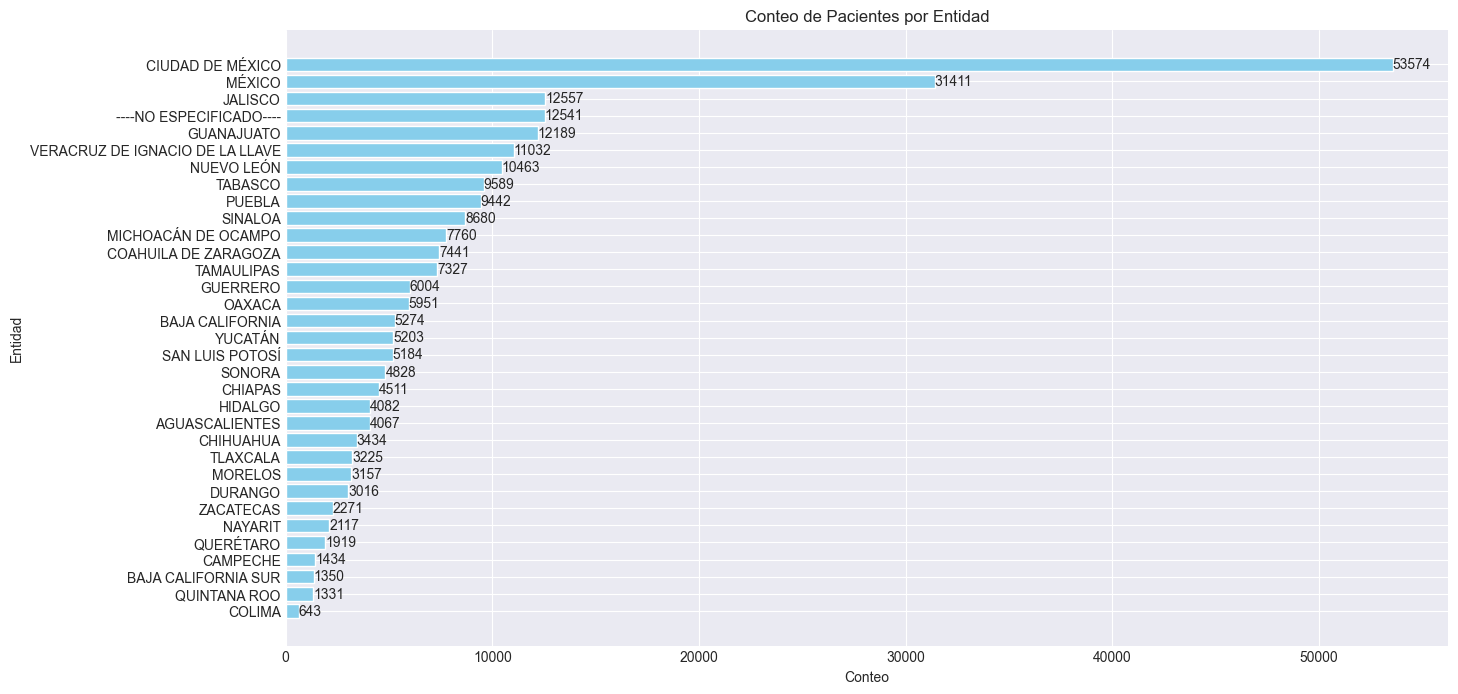

In [156]:
data = df_entidad.copy()
data.sort_values(by='cant_pacientes', inplace=True)
keys = data['ENTIDAD']
values = data['cant_pacientes']

# Creating the horizontal bar plot
plt.figure(figsize=(15, 8))
bars = plt.barh(keys, values, color='skyblue')

# Adding labels next to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width()}', va='center')

# Adding title and labels
plt.title('Conteo de Pacientes por Entidad')
plt.xlabel('Conteo')
plt.ylabel('Entidad')

# Display the plot
plt.show()

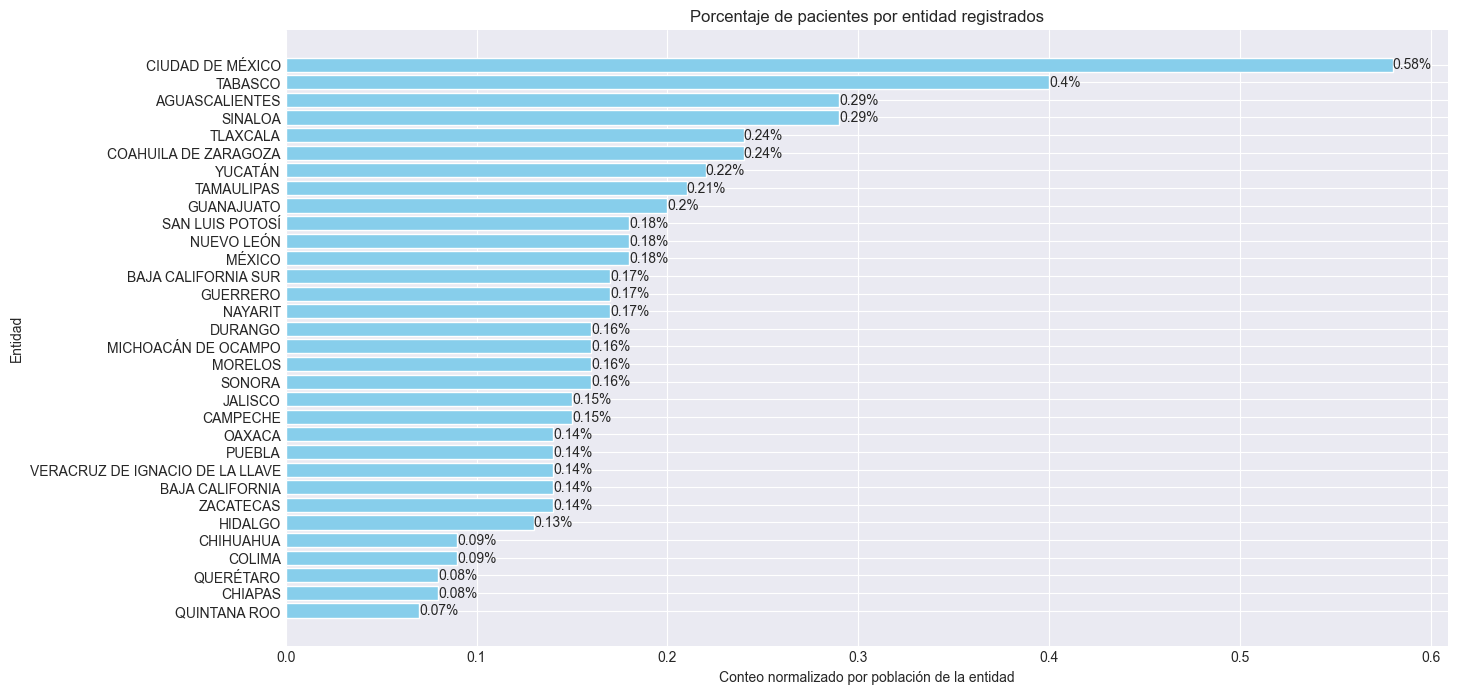

In [157]:
data = df_entidad.copy()
data.drop([32], inplace=True)
data.sort_values(by='cant_pacientes_normalizada', inplace=True)
keys = data['ENTIDAD']
values = data['cant_pacientes_normalizada']

# Creating the horizontal bar plot
plt.figure(figsize=(15, 8))
bars = plt.barh(keys, values, color='skyblue')

# Adding labels next to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()}%', va='center')

# Adding title and labels
plt.title('Porcentaje de pacientes por entidad registrados')
plt.xlabel('Conteo normalizado por población de la entidad')
plt.ylabel('Entidad')

# Display the plot
plt.show()

### ORIGEN - USMER o fuera de USMER (Unidades Monitoras de Enfermedades RespiratoriaS)

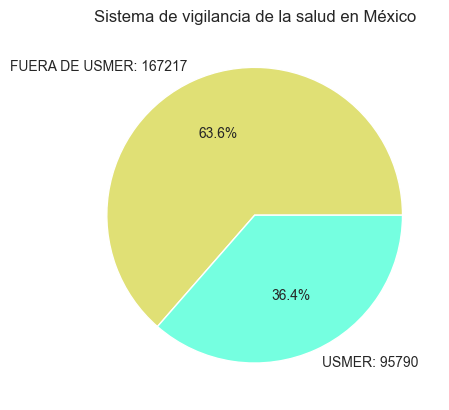

In [158]:
grafica_pastel('ORIGEN',
               titulo='Sistema de vigilancia de la salud en México',
               diccionario = {1: "USMER", 2: "FUERA DE USMER",},
               explode=(0.0, 0),
               colors=[(0.8, .8, .1, 0.6), (0.1, 1, .8, 0.6)])

### SECTOR - Institución de Salud que proporcionó el cuidado al paciente

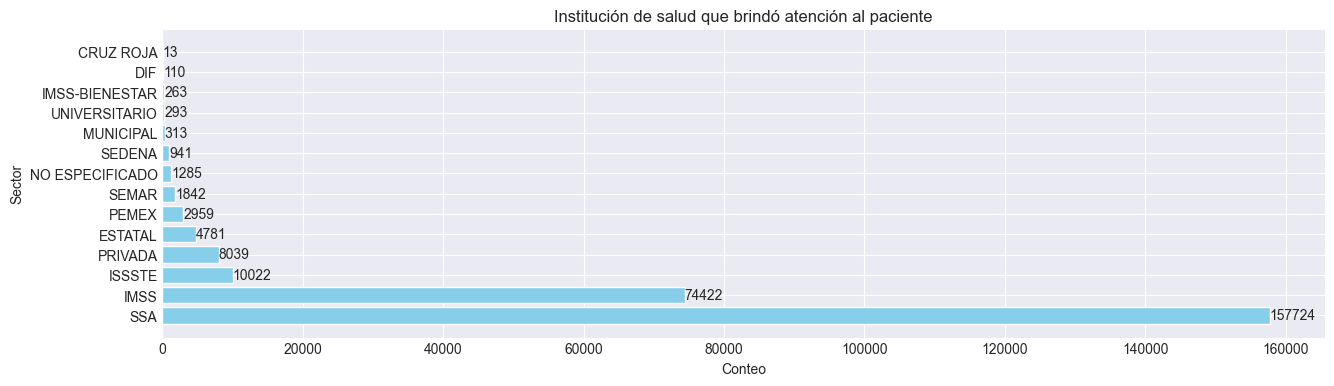

In [159]:
SECTOR = {
    1: "CRUZ ROJA",
    2: "DIF",
    3: "ESTATAL",
    4: "IMSS",
    5: "IMSS-BIENESTAR",
    6: "ISSSTE",
    7: "MUNICIPAL",
    8: "PEMEX",
    9: "PRIVADA",
    10: "SEDENA",
    11: "SEMAR",
    12: "SSA",
    13: "UNIVERSITARIO",
    99: "NO ESPECIFICADO"
}
sector_value_counts = pd.Series([SECTOR[item] for item in df_clean['SECTOR']]).value_counts()


# Using value_counts
value_counts = sector_value_counts

# Extracting keys (unique values) and values (counts)
keys = value_counts.index.tolist()
values = value_counts.values.tolist()

# Creating the horizontal bar plot
plt.figure(figsize=(15, 4))
bars = plt.barh(keys, values, color='skyblue')

# Adding labels next to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()}', va='center')

# Adding title and labels
plt.title('Institución de salud que brindó atención al paciente')
plt.xlabel('Conteo')
plt.ylabel('Sector')

# Display the plot
plt.show()

### SEXO - Sexo del paciente

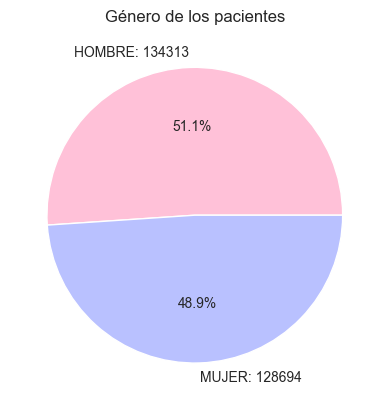

In [160]:
grafica_pastel('SEXO',
               titulo='Género de los pacientes',
               diccionario = {1: "MUJER", 2: "HOMBRE", 3: "NO ESPECIFICADO"},
               explode=(0.0, 0),
               colors=[(1, 0.2, 0.5, 0.3),(0.1, 0.2, 1, 0.3)])

### TIPO_PACIENTE - Indica si el paciente tuvo que ser hospitalizado o si fue ambulatorio

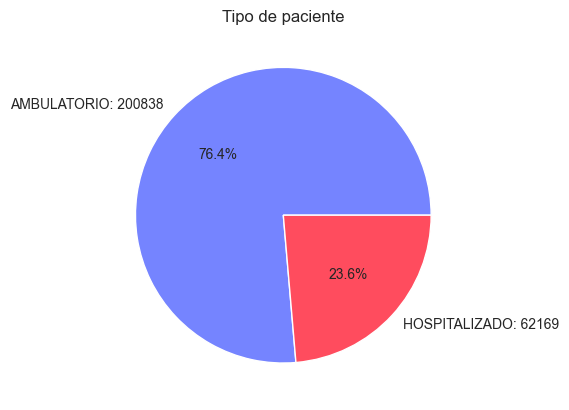

In [161]:
grafica_pastel('TIPO_PACIENTE',
               titulo='Tipo de paciente',
               diccionario = {1: "AMBULATORIO", 2: "HOSPITALIZADO",},
               explode=(0.0, 0),
               colors=[(0.1, 0.2, 1, 0.6), (1, 0.0, 0.1, 0.7)])

### INTUBADO

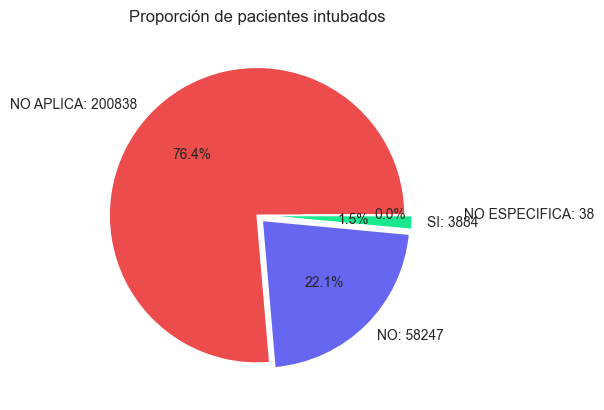

In [162]:
grafica_pastel('INTUBADO',
               titulo='Proporción de pacientes intubados',
               diccionario = None,
               explode=(0.0,0.05,0.05,0.3),
               colors=[(0.9, 0.0, .0, 0.7), (0, 0.0, 0.9, 0.6), (0.0, 0.9, .5, 0.9), (0.9, 0.9, .0, 1)])

### NEUMONIA

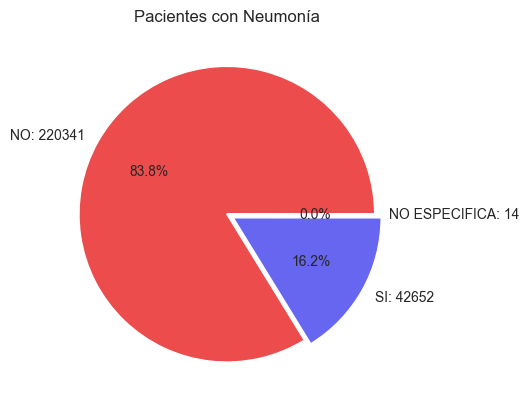

In [163]:
grafica_pastel('NEUMONIA',
               titulo='Pacientes con Neumonía',
               diccionario = None,
               explode=(0.0,0.05,0.0),
               colors=[(0.9, 0.0, .0, 0.7), (0, 0.0, 0.9, 0.6), (0.0, 0.9, .5, 0.9), (0.9, 0.9, .0, 1)])

### NACIONALIDAD

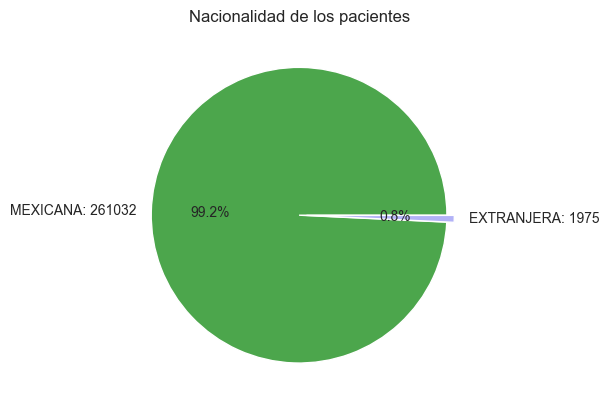

In [164]:
grafica_pastel('NACIONALIDAD',
               titulo='Nacionalidad de los pacientes',
               diccionario = {1: "MEXICANA", 2: "EXTRANJERA",},
               explode=(0.0,0.05),
               colors=[(0.0, 0.5, .0, 0.7), (0, 0.0, 0.9, 0.3)])

### EMBARAZO

In [165]:
data = df_clean[(df_clean['EMBARAZO'] == 1) | (df_clean['EMBARAZO'] == 2)].copy()
data['EMBARAZO'].value_counts()

2    126077
1      2064
Name: EMBARAZO, dtype: int64

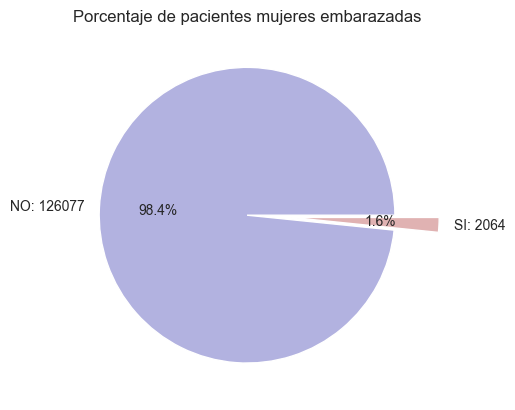

In [166]:
data = df_clean[(df_clean['EMBARAZO'] == 1) | (df_clean['EMBARAZO'] == 2)].copy()
dictionary = {1: "SI",
                      2: "NO",
                      97: "NO APLICA",
                      98: "SE IGNORA",
                      99: "NO ESPECIFICA"}
value_counts = pd.Series([dictionary[item] for item in data['EMBARAZO']]).value_counts()

plt.pie(value_counts,
        labels = ['NO: ' + str(value_counts[0]),
                  'SI: ' + str(value_counts[1]),],
        explode=(0.0,0.3),
        colors = [(0.0, 0.0, .6, 0.3), (.6, 0.0, 0.0, 0.3)],
        autopct='%1.1f%%')
plt.title('Porcentaje de pacientes mujeres embarazadas');

### Lengua indígena

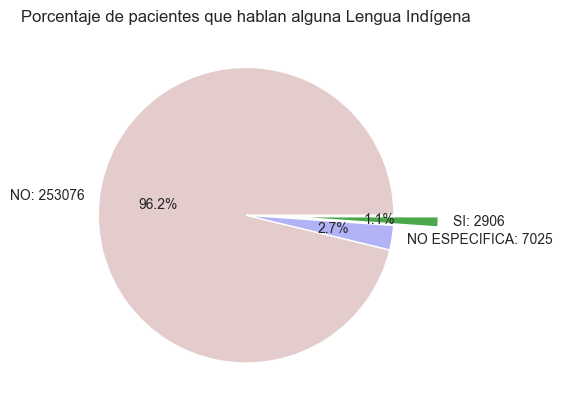

In [167]:
grafica_pastel('HABLA_LENGUA_INDIG',
               titulo='Porcentaje de pacientes que hablan alguna Lengua Indígena',
               diccionario = None,
               explode=(0.0,0, .3),
               colors=[(0.5, 0.0, .0, 0.2), (0, 0.0, 0.9, 0.3), (0.0, 0.5, .0, 0.7)])

### DIABETES

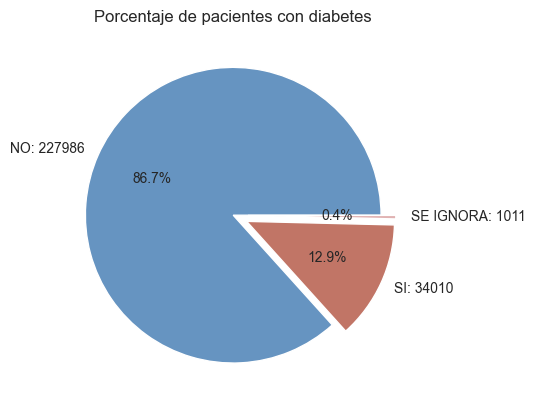

In [168]:
grafica_pastel('DIABETES',
               titulo='Porcentaje de pacientes con diabetes',
               diccionario = None,
               explode=(0.0,.1, 0.1),
               colors=[(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### EPOC

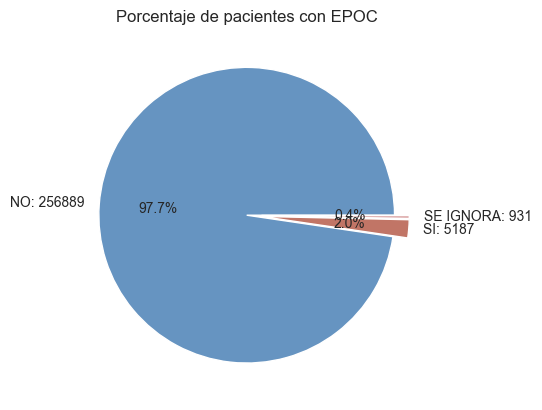

In [169]:
grafica_pastel('EPOC',
               titulo = 'Porcentaje de pacientes con EPOC',
               diccionario = None,
               explode=(0.0,.1, 0.1),
               colors = [(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### ASMA

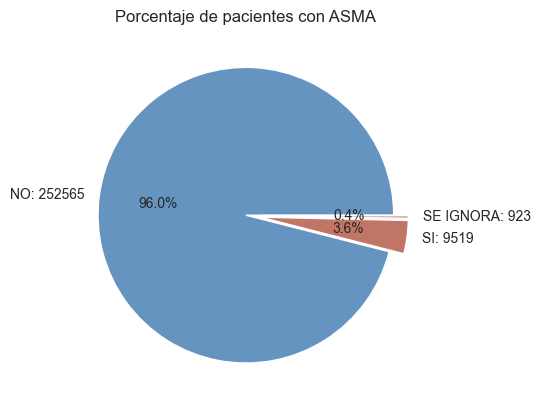

In [170]:
grafica_pastel('ASMA',
               titulo = 'Porcentaje de pacientes con ASMA',
               diccionario = None,
               explode=(0.0,.1, 0.1),
               colors = [(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### INMUNOSUPR

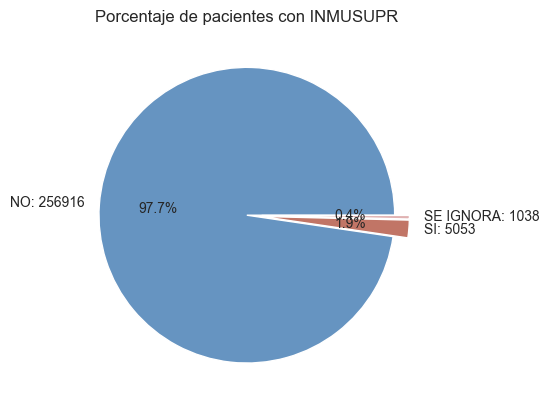

In [171]:
grafica_pastel('INMUSUPR',
               titulo = 'Porcentaje de pacientes con INMUSUPR',
               diccionario = None,
               explode=(0.0,.1, 0.1),
               colors = [(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### HIPERTENSION

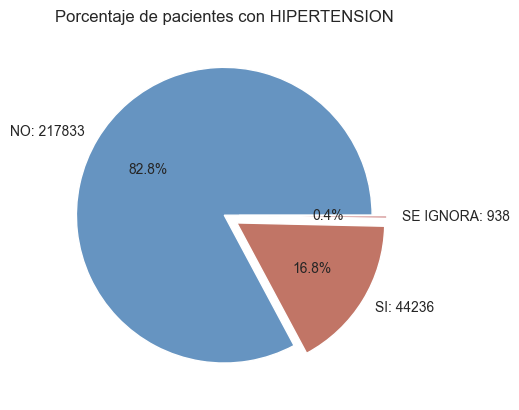

In [172]:
grafica_pastel('HIPERTENSION',
               titulo = 'Porcentaje de pacientes con HIPERTENSION',
               diccionario = None,
               explode=(0.0,.1, 0.1),
               colors = [(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### CARDIOVASCULAR

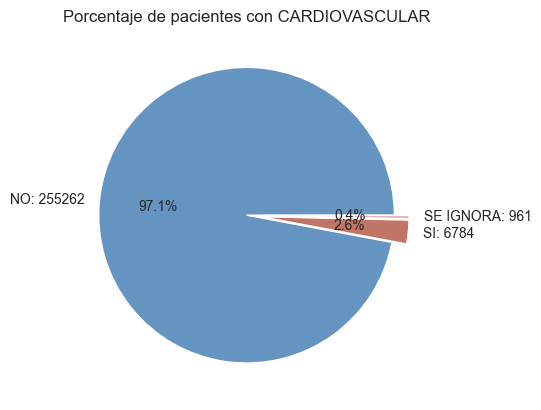

In [173]:
grafica_pastel('CARDIOVASCULAR',
               titulo='Porcentaje de pacientes con CARDIOVASCULAR',
               diccionario=None,
               explode=(0.0, .1, 0.1),
               colors=[(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### OBESIDAD

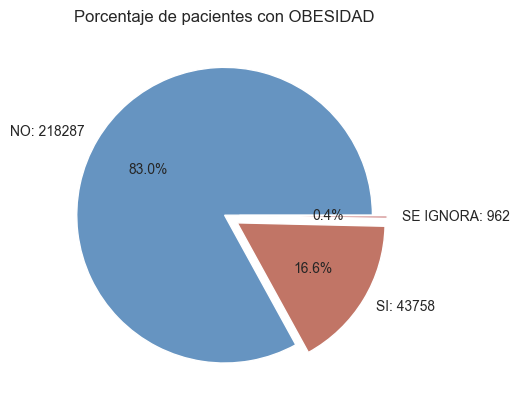

In [174]:
grafica_pastel('OBESIDAD',
               titulo='Porcentaje de pacientes con OBESIDAD',
               diccionario=None,
               explode=(0.0, .1, 0.1),
               colors=[(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### RENAL_CRONICA

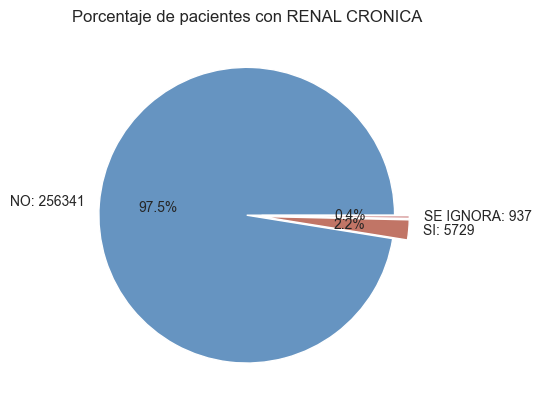

In [175]:
grafica_pastel('RENAL_CRONICA',
               titulo='Porcentaje de pacientes con RENAL CRONICA',
               diccionario=None,
               explode=(0.0, .1, 0.1),
               colors=[(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### TABAQUISMO

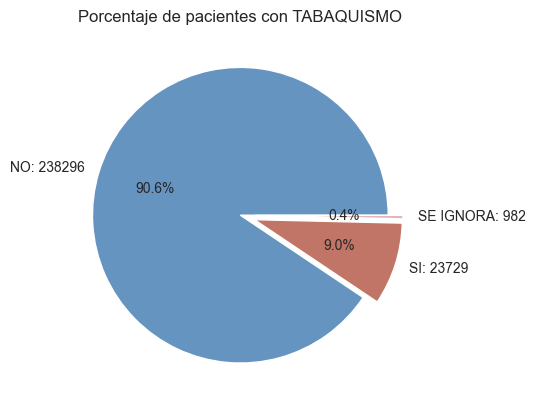

In [176]:
grafica_pastel('TABAQUISMO',
               titulo='Porcentaje de pacientes con TABAQUISMO',
               diccionario=None,
               explode=(0.0, .1, 0.1),
               colors=[(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### UCI

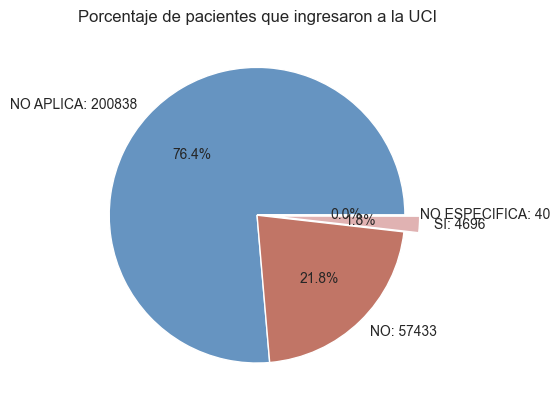

In [177]:
grafica_pastel('UCI',
               titulo='Porcentaje de pacientes que ingresaron a la UCI',
               diccionario=None,
               explode=(0.0, 0, 0.1, .0),
               colors=[(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

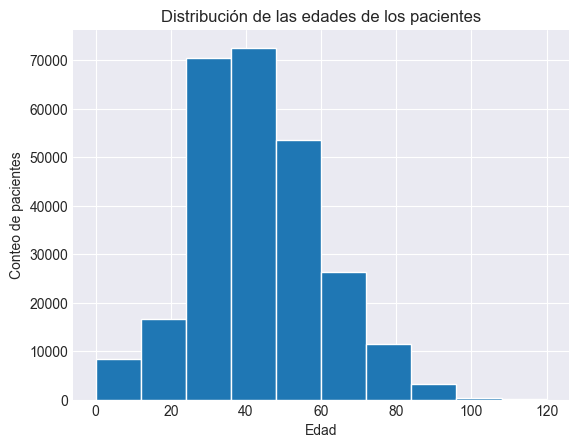

In [178]:
df_clean['EDAD'].plot(kind='hist', title="Distribución de las edades de los pacientes")
plt.xlabel('Edad')
plt.ylabel('Conteo de pacientes')
plt.show();

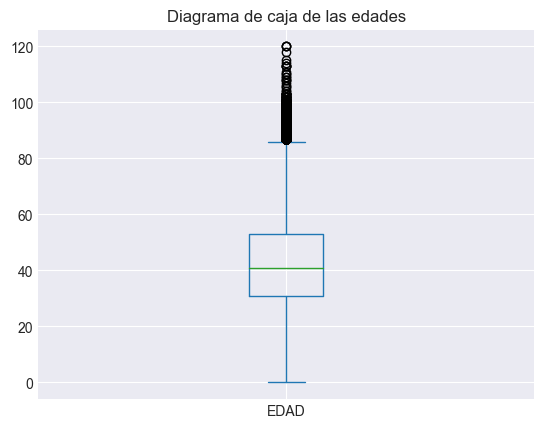

In [179]:
df_clean['EDAD'].plot(kind='box')
plt.title('Diagrama de caja de las edades');

### RESULTADO - Resultado de las pruebas COVID

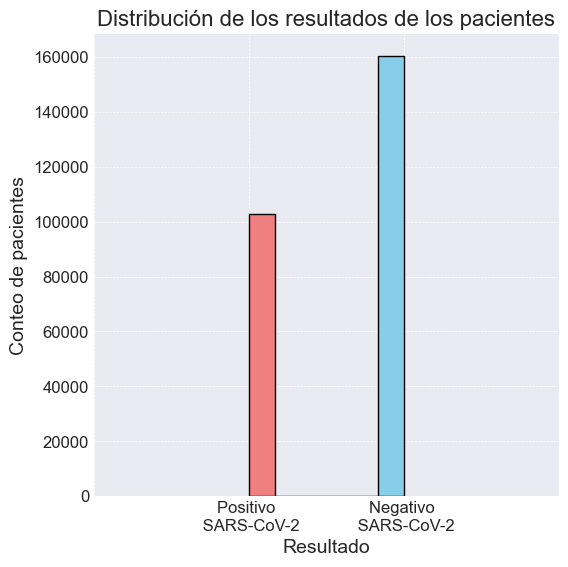

In [180]:
# Set the style for the plot
plt.style.use('seaborn-darkgrid')

# Create the plot with a specified figure size
plt.figure(figsize=(6, 6))

# Plot the histogram
ax = df_clean['RESULTADO'].plot(kind='hist', bins=6, color='skyblue', edgecolor='black')

# Set the title and labels with larger fonts
plt.title("Distribución de los resultados de los pacientes", fontsize=16)
plt.xlabel('Resultado', fontsize=14)
plt.ylabel('Conteo de pacientes', fontsize=14)

# Customize the x-ticks
plt.xticks([0, 1, 2,3], ['', 'Positivo \n SARS-CoV-2', 'Negativo \n SARS-CoV-2', ''], fontsize=12)

# Customize the y-ticks
plt.yticks(fontsize=12)

# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Change colors of each bar
bars = ax.patches
bars[0].set_facecolor('lightcoral')
bars[1].set_facecolor('lightgreen')
bars[2].set_facecolor('lightgreen')
bars[3].set_facecolor('lightgreen')
#lightcoral

# Show the plot
plt.show()

## Análisis de correlación
Puede proporcionar información sobre posibles predicores importantes para un análisis posterior.

## Análisis de distribución de variables
Examina la distribución de las variables en los datos para detectar sesgos o asimetrías.

## Segmentación
Dividir los datos en segmentos o grupos con características similares para analizar patrones específicos en elgrrupo. 

### Por rangos de edad

In [181]:
df_seg_edad = df_clean[['EDAD', 'RESULTADO', 'FECHA_DEF']].copy()

In [182]:
def discretizar_edad(edad):
    if edad < 12:
        return 'niño'
    elif (edad >= 12) & (edad < 18):
        return  'joven'
    elif (edad >= 18) & (edad < 30):
        return 'adulto joven'
    elif (edad >= 30) & (edad < 60):
        return 'adulto'
    elif edad >= 60:
        return 'adulto mayor'

In [183]:
df_seg_edad['EDAD_DISCRETA'] = [discretizar_edad(edad) for edad in df_seg_edad['EDAD']]

In [184]:
df_seg_edad.head(15)

,EDAD,RESULTADO,FECHA_DEF,EDAD_DISCRETA
0,74,2,2200-01-01,adulto mayor
1,71,2,2200-01-01,adulto mayor
2,50,1,2200-01-01,adulto
3,25,1,2200-01-01,adulto joven
4,28,2,2200-01-01,adulto joven
5,67,2,2200-01-01,adulto mayor
6,44,2,2200-01-01,adulto
7,62,2,2200-01-01,adulto mayor
8,30,2,2200-01-01,adulto
9,30,2,2200-01-01,adulto


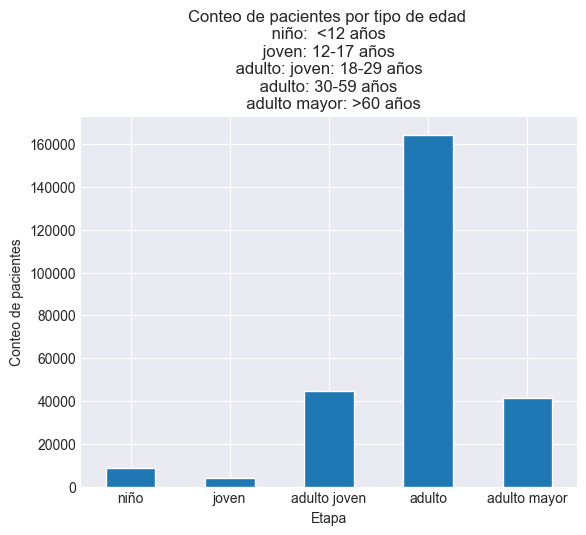

In [185]:
df_seg_edad['EDAD_DISCRETA'].value_counts().reindex(['niño','joven','adulto joven','adulto','adulto mayor']).plot(kind='bar')
plt.title('Conteo de pacientes por tipo de edad \n niño:  <12 años \n joven: 12-17 años \n adulto: joven: 18-29 años \n adulto: 30-59 años \n  adulto mayor: >60 años')
plt.ylabel('Conteo de pacientes')
plt.xlabel('Etapa')
plt.xticks(rotation=0)
plt.show()

### Por rangos de edad y resultado

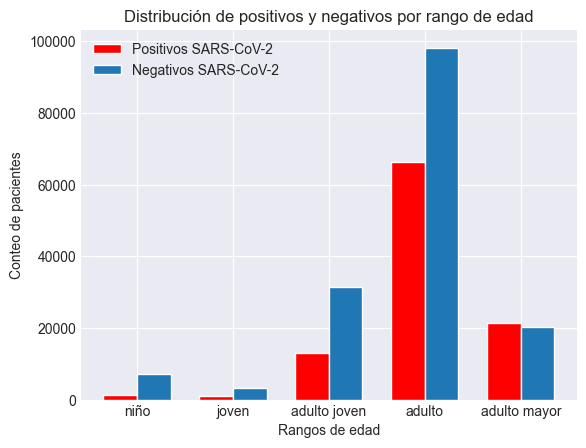

In [186]:
rangos = ['niño','joven','adulto joven','adulto','adulto mayor']
positivos = []
negativos = []

for rango in rangos:
    resultados_por_rango = dict(df_seg_edad.loc[df_seg_edad['EDAD_DISCRETA'] == rango, 'RESULTADO'].value_counts())
    positivos.append(resultados_por_rango[1])
    negativos.append(resultados_por_rango[2])
    
    

# Sample data
categories = rangos
values1 = positivos
values2 = negativos

# Define the position of bars
bar_width = 0.35
index = np.arange(len(categories))

# Creating the bar plot
fig, ax = plt.subplots()
bar1 = ax.bar(index, values1, bar_width, label='Positivos SARS-CoV-2', color='r')
bar2 = ax.bar(index + bar_width, values2, bar_width, label='Negativos SARS-CoV-2')

# Adding title and labels
plt.title('Distribución de positivos y negativos por rango de edad')
plt.xlabel('Rangos de edad')
plt.ylabel('Conteo de pacientes')
plt.xticks(index + bar_width / 2, categories)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [187]:
df_seg_edad['FECHA_DEF']

0        2200-01-01
1        2200-01-01
2        2200-01-01
3        2200-01-01
4        2200-01-01
            ...    
263002   2200-01-01
263003   2020-05-07
263004   2020-05-18
263005   2200-01-01
263006   2200-01-01
Name: FECHA_DEF, Length: 263007, dtype: datetime64[ns]

In [188]:
df_seg_edad['DEFUNCION'] = [0 if fecha==pd.to_datetime('2200-01-01') else 1 for fecha in df_seg_edad['FECHA_DEF']]
df_seg_edad.head()

,EDAD,RESULTADO,FECHA_DEF,EDAD_DISCRETA,DEFUNCION
0,74,2,2200-01-01,adulto mayor,0
1,71,2,2200-01-01,adulto mayor,0
2,50,1,2200-01-01,adulto,0
3,25,1,2200-01-01,adulto joven,0
4,28,2,2200-01-01,adulto joven,0


In [189]:
df_seg_edad['DEFUNCION'].value_counts()

0    258465
1      4542
Name: DEFUNCION, dtype: int64

In [190]:
df_riesgos = df_clean[['FECHA_DEF', 'RESULTADO',
                       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESIDAD','RENAL_CRONICA', 'TABAQUISMO', 'UCI']
                    ].copy()# Filtrar por los que dieron positivo
df_riesgos = df_riesgos[df_riesgos['RESULTADO']==1]
#Agregar column de defuncion
df_riesgos['DEFUNCION'] = [0 if fecha==pd.to_datetime('2200-01-01') else 1 for fecha in df_riesgos['FECHA_DEF']]
#eliminar colum de fecha def
df_riesgos.drop(columns = 'FECHA_DEF', inplace=True)
#Filtrar por los que fallecieron
df_riesgos = df_riesgos[df_riesgos['DEFUNCION']==1]
df_riesgos

,RESULTADO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,UCI,DEFUNCION
96,1,1,2,2,1,1,1,1,1,2,2,1
190,1,2,2,2,2,2,2,2,2,1,2,1
306,1,2,2,2,2,2,2,2,2,2,2,1
323,1,2,2,2,2,2,2,2,2,2,2,1
326,1,2,2,2,2,1,2,1,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
262982,1,1,1,2,2,1,2,1,2,2,2,1
262984,1,1,2,2,2,1,1,2,2,2,2,1
262996,1,2,2,2,2,2,2,2,2,2,97,1
263003,1,1,1,2,2,2,2,1,2,2,2,1


In [191]:
riesgos = ['DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESIDAD','RENAL_CRONICA', 'TABAQUISMO', 'UCI']
conteos = []

for riesgo in tqdm(riesgos):
    conteos.append(dict(df_riesgos[riesgo].value_counts())[1])

100%|██████████| 10/10 [00:00<00:00, 3967.75it/s]


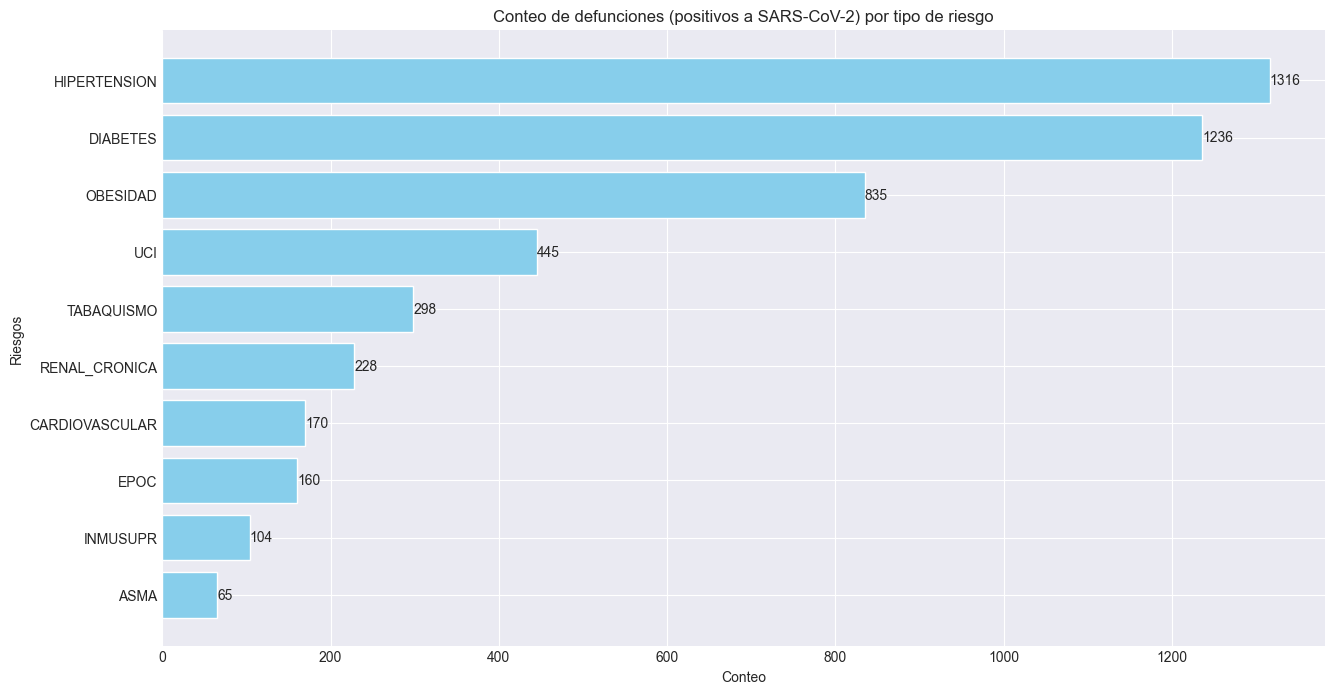

In [192]:
data = pd.DataFrame({'riesgos' : riesgos, 'conteos':conteos})
data.sort_values(by='conteos', inplace=True)
keys = data['riesgos']
values = data['conteos']

# Creating the horizontal bar plot
plt.figure(figsize=(15, 8))
bars = plt.barh(keys, values, color='skyblue')

# Adding labels next to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width()}', va='center')

# Adding title and labels
plt.title('Conteo de defunciones (positivos a SARS-CoV-2) por tipo de riesgo')
plt.xlabel('Conteo')
plt.ylabel('Riesgos')

# Display the plot
plt.show()

### Defunciones por institución de salud

In [193]:
df_def = df_clean[['SECTOR', 'FECHA_DEF']].copy()
df_def['DEF'] = [0 if fecha == pd.to_datetime('2200-01-01') else 1 for fecha in df_def['FECHA_DEF']]
df_def.drop(columns = 'FECHA_DEF', inplace=True)
df_def['SECTOR'] = [SECTOR[clave] for clave in df_def['SECTOR']]
df_def

,SECTOR,DEF
0,SSA,0
1,IMSS,0
2,IMSS,0
3,IMSS,0
4,IMSS,0
...,...,...
263002,SSA,0
263003,IMSS,1
263004,IMSS,1
263005,SSA,0


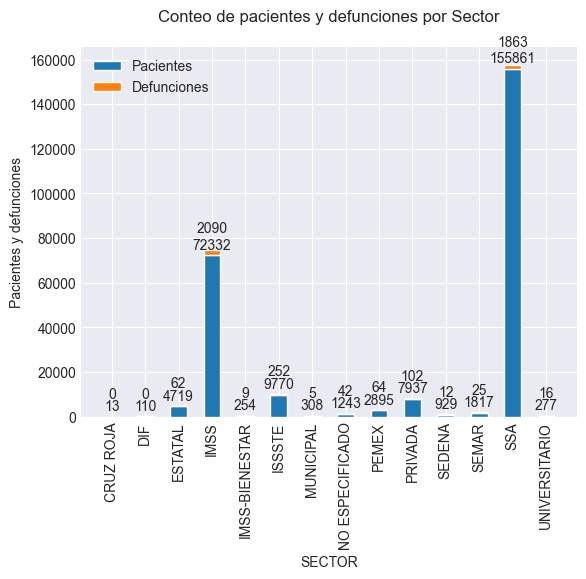

In [194]:
# Create DataFrame
df = df_def

# Count total occurrences and occurrences of 1 for each category
counts = df.groupby('SECTOR')['DEF'].agg(['count', 'sum']).reset_index()
counts.columns = ['SECTOR', 'Total', 'DEF']

# Calculate occurrences of 0
counts['Vivo'] = counts['Total'] - counts['DEF']

# Data for the bar chart
categories = counts['SECTOR']
count_0 = counts['Vivo']
count_1 = counts['DEF']

# Plotting the stacked bar chart
fig, ax = plt.subplots()
bar_width = 0.5

# Plotting the bars
bars_0 = ax.bar(categories, count_0, bar_width, label='Pacientes')
bars_1 = ax.bar(categories, count_1, bar_width, bottom=count_0, label='Defunciones')

    
for bar in bars_0:
    yval = bar.get_height() + bar.get_y()+1500
    xval = bar.get_x() + bar.get_width() / 2
    ax.text(xval, yval, int(bar.get_height()), ha='center', va='bottom')

# Adding labels on top of the bars
for bar in bars_1:
    yval = bar.get_height() + bar.get_y() +7000
    xval = bar.get_x() + bar.get_width() / 2
    ax.text(xval, yval, int(bar.get_height()), ha='center', va='bottom')

# Rotate x-tick labels
plt.xticks(rotation=90)

# Adding labels and title
ax.set_xlabel('SECTOR')
ax.set_ylabel('Pacientes y defunciones')
ax.set_title('Conteo de pacientes y defunciones por Sector\n')
ax.legend()

# Display the chart
plt.show()


In [195]:
counts['relacionDEFvivo'] = round(counts['DEF']/counts['Vivo']*100, 2)
counts = counts.sort_values(by='relacionDEFvivo', ascending=False)
counts

,SECTOR,Total,DEF,Vivo,relacionDEFvivo
13,UNIVERSITARIO,293,16,277,5.78
4,IMSS-BIENESTAR,263,9,254,3.54
7,NO ESPECIFICADO,1285,42,1243,3.38
3,IMSS,74422,2090,72332,2.89
5,ISSSTE,10022,252,9770,2.58
8,PEMEX,2959,64,2895,2.21
6,MUNICIPAL,313,5,308,1.62
11,SEMAR,1842,25,1817,1.38
2,ESTATAL,4781,62,4719,1.31
9,PRIVADA,8039,102,7937,1.29


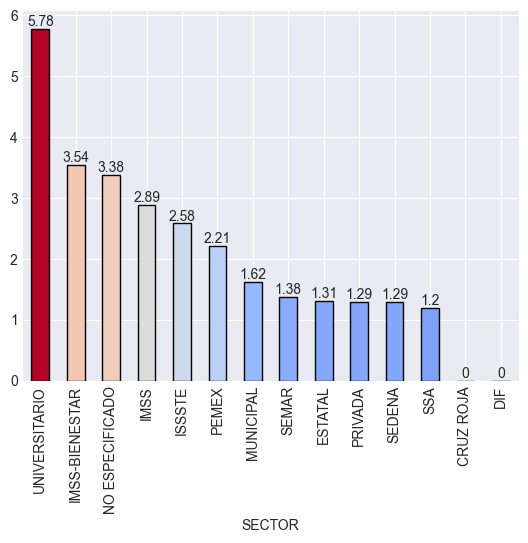

In [196]:
# Normalize the 'relacionDEFvivo' values to range [0, 1] for colormap
norm = plt.Normalize(counts['relacionDEFvivo'].min(), counts['relacionDEFvivo'].max())
cmap = plt.get_cmap('coolwarm')  # You can choose other colormaps like 'viridis', 'plasma', etc.
colors = cmap(norm(counts['relacionDEFvivo']))

# Create the bar plot
ax = counts.plot(kind='bar', x='SECTOR', y='relacionDEFvivo', legend=False, color=colors, edgecolor='black')


# Set the x-tick labels to the sorted 'SECTOR' values
plt.xticks(ticks=range(len(counts)), labels=counts['SECTOR'], rotation=90)

# Add the amount at the top of each bar
for i in ax.containers:
    ax.bar_label(i)

# Show the plot
plt.show()

## Exploración de series temporales
Si los datos tienen una dimensión temporal, realizar un análisis de series temporales para identificar tendencias, estacionalidades, y ciclos en los datos a lo largo del tiempo.

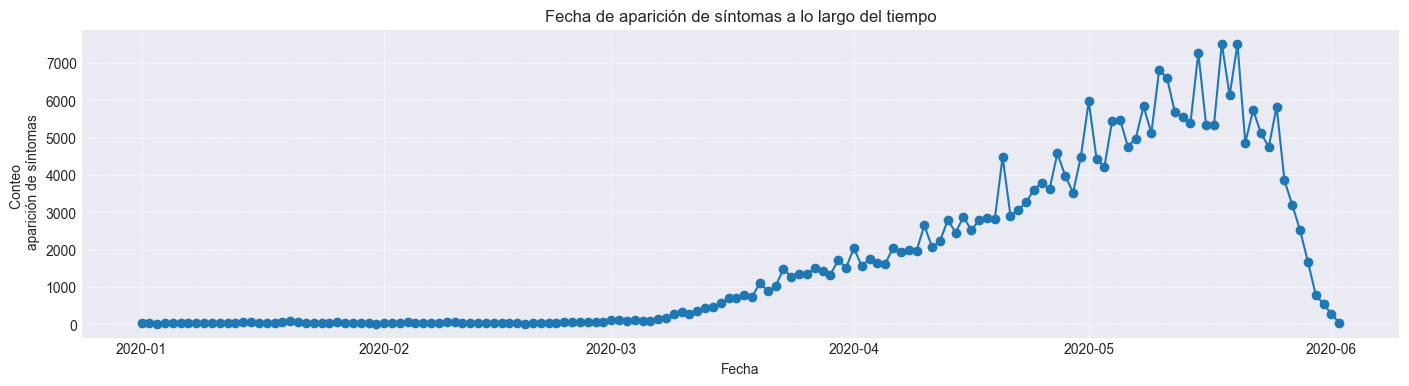

In [197]:
fecha_sintomas = dict(df_clean['FECHA_SINTOMAS'].value_counts())
fecha_sintomas = dict(sorted(fecha_sintomas.items()))

plt.figure(figsize=(17,4))
fechas = list(fecha_sintomas.keys())
conteo = list(fecha_sintomas.values())
plt.scatter(fechas, conteo)
plt.plot(fechas, conteo)
plt.title('Fecha de aparición de síntomas a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Conteo \n aparición de síntomas')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

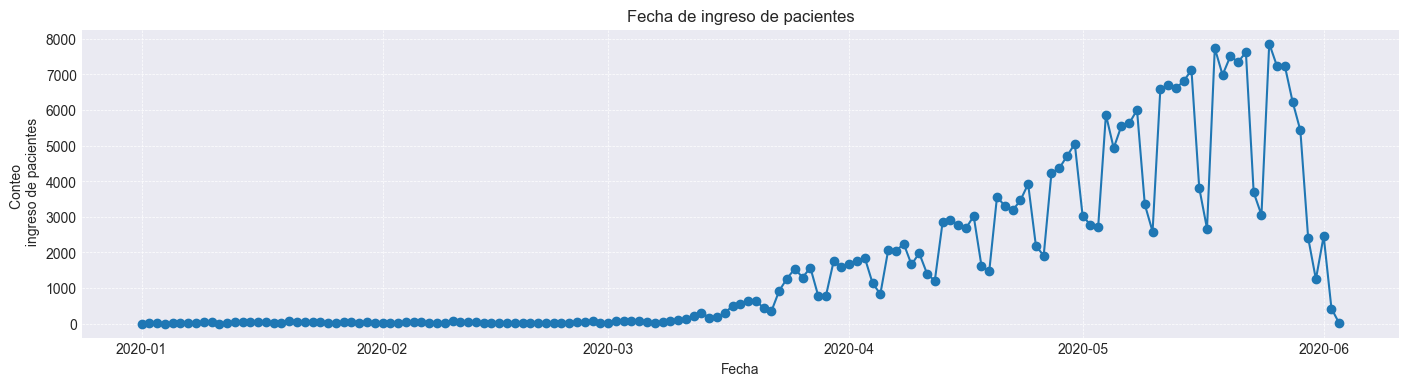

In [198]:
fecha_ingreso = dict(df_clean['FECHA_INGRESO'].value_counts())
fecha_ingreso = dict(sorted(fecha_ingreso.items()))

plt.figure(figsize=(17,4))
fechas = list(fecha_ingreso.keys())
conteo = list(fecha_ingreso.values())
plt.scatter(fechas, conteo)
plt.plot(fechas, conteo)
plt.title('Fecha de ingreso de pacientes')
plt.xlabel('Fecha')
plt.ylabel('Conteo \n ingreso de pacientes')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

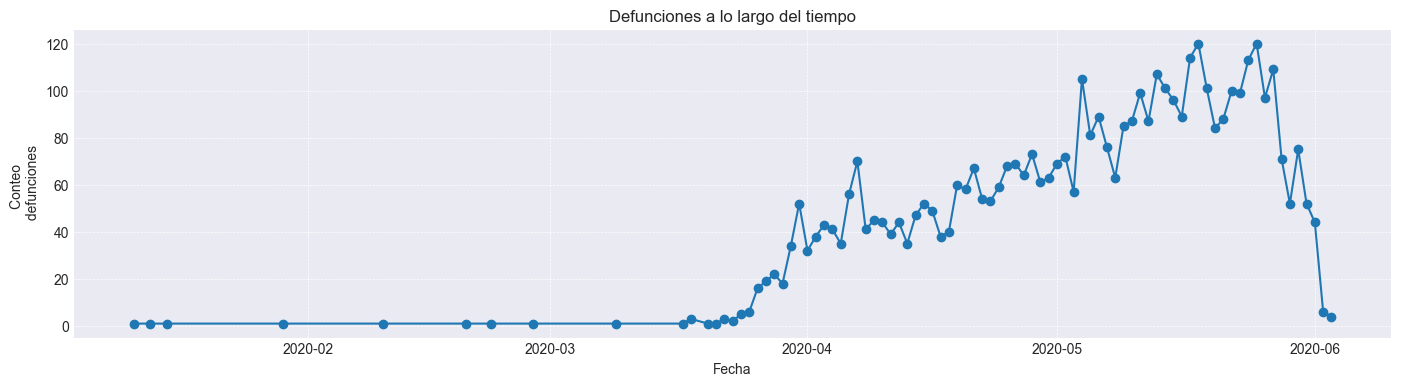

In [199]:
fecha_def = df_clean['FECHA_DEF'][df_clean['FECHA_DEF'] != pd.to_datetime('2200-01-01')]
fecha_def = dict(fecha_def.value_counts())
fecha_def = dict(sorted(fecha_def.items()))

plt.figure(figsize=(17,4))
fechas_defunciones = list(fecha_def.keys())
conteo_defunciones = list(fecha_def.values())
plt.scatter(fechas_defunciones, conteo_defunciones)
plt.plot(fechas_defunciones, conteo_defunciones)
plt.title('Defunciones a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Conteo \n defunciones')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

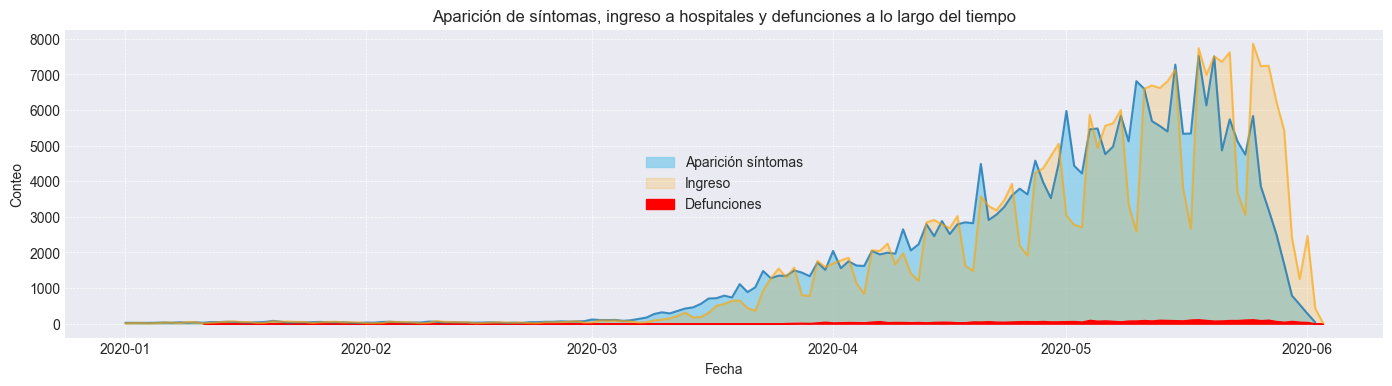

In [200]:
plt.figure(figsize=(17,4))

#Sintomas
fecha_sintomas = dict(df_clean['FECHA_SINTOMAS'].value_counts())
fecha_sintomas = dict(sorted(fecha_sintomas.items()))
fechas = list(fecha_sintomas.keys())
conteo = list(fecha_sintomas.values())
#plt.scatter(fechas, conteo)
plt.plot(fechas, conteo, alpha=0.8)
plt.fill_between(fechas, conteo, color="skyblue", alpha=0.8, label='Aparición síntomas')

#Ingreso
fecha_ingreso = dict(df_clean['FECHA_INGRESO'].value_counts())
fecha_ingreso = dict(sorted(fecha_ingreso.items()))
fechas = list(fecha_ingreso.keys())
conteo = list(fecha_ingreso.values())
#plt.scatter(fechas, conteo)
plt.plot(fechas, conteo, c='orange', alpha=.6)
plt.fill_between(fechas, conteo, color="orange", alpha=0.2, label='Ingreso')

#Defunciones
fecha_def = df_clean['FECHA_DEF'][df_clean['FECHA_DEF'] != pd.to_datetime('2200-01-01')]
fecha_def = dict(fecha_def.value_counts())
fecha_def = dict(sorted(fecha_def.items()))
fechas_defunciones = list(fecha_def.keys())
conteo_defunciones = list(fecha_def.values())
#plt.scatter(fechas_defunciones, conteo_defunciones)
#plt.plot(fechas_defunciones, conteo_defunciones)
plt.fill_between(fechas_defunciones, conteo_defunciones, color="red", alpha=1, label='Defunciones')


plt.title('Aparición de síntomas, ingreso a hospitales y defunciones a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Conteo')
plt.legend(loc = 'center')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Modelado de datos

## Preprocesar datos

In [201]:
data = df_clean.copy()
data = data[['ORIGEN', 'SEXO', 'TIPO_PACIENTE','INTUBADO', 'NEUMONIA', 'EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'UCI', 'RESULTADO', 'FECHA_DEF']]
data

,ORIGEN,SEXO,TIPO_PACIENTE,INTUBADO,NEUMONIA,EDAD,EMBARAZO,DIABETES,EPOC,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,UCI,RESULTADO,FECHA_DEF
0,2,2,1,97,2,74,97,1,2,2,2,1,2,2,2,97,2,2200-01-01
1,1,1,2,2,2,71,2,1,1,2,2,1,2,1,99,2,2,2200-01-01
2,1,2,2,2,1,50,97,2,2,2,2,2,2,2,99,2,1,2200-01-01
3,2,1,1,97,2,25,2,2,2,2,2,1,2,2,99,97,1,2200-01-01
4,1,1,1,97,2,28,2,2,2,2,2,2,2,2,99,97,2,2200-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263002,2,2,1,97,2,39,97,2,2,2,2,2,2,2,1,97,1,2200-01-01
263003,2,1,2,2,1,53,2,1,1,2,2,1,2,2,99,2,1,2020-05-07
263004,1,1,2,2,2,65,2,1,2,2,2,2,1,2,99,2,1,2020-05-18
263005,2,2,2,2,1,71,97,2,2,2,2,2,2,2,2,2,1,2200-01-01


In [202]:
def discretizar_edad(edad):
    if edad < 12:
        return 0
    elif (edad >= 12) & (edad < 18):
        return 1
    elif (edad >= 18) & (edad < 30):
        return 2
    elif (edad >= 30) & (edad < 60):
        return 3
    elif edad >= 60:
        return 4


data['EDAD_DISCRETA'] = [discretizar_edad(edad) for edad in data['EDAD']]
data.drop(columns='EDAD', inplace=True)
data

,ORIGEN,SEXO,TIPO_PACIENTE,INTUBADO,NEUMONIA,EMBARAZO,DIABETES,EPOC,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,UCI,RESULTADO,FECHA_DEF,EDAD_DISCRETA
0,2,2,1,97,2,97,1,2,2,2,1,2,2,2,97,2,2200-01-01,4
1,1,1,2,2,2,2,1,1,2,2,1,2,1,99,2,2,2200-01-01,4
2,1,2,2,2,1,97,2,2,2,2,2,2,2,99,2,1,2200-01-01,3
3,2,1,1,97,2,2,2,2,2,2,1,2,2,99,97,1,2200-01-01,2
4,1,1,1,97,2,2,2,2,2,2,2,2,2,99,97,2,2200-01-01,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263002,2,2,1,97,2,97,2,2,2,2,2,2,2,1,97,1,2200-01-01,3
263003,2,1,2,2,1,2,1,1,2,2,1,2,2,99,2,1,2020-05-07,3
263004,1,1,2,2,2,2,1,2,2,2,2,1,2,99,2,1,2020-05-18,4
263005,2,2,2,2,1,97,2,2,2,2,2,2,2,2,2,1,2200-01-01,4


In [203]:
data['DEFUNCION'] = [0 if fecha == pd.to_datetime('2200-01-01') else 1 for fecha in data['FECHA_DEF']]
data.drop(columns='FECHA_DEF', inplace=True)

In [204]:
attributos = ['ORIGEN', 'SEXO', 'TIPO_PACIENTE','INTUBADO', 'NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'UCI']
atributos = []

for atributo in attributos:
    data[atributo] = data[atributo].replace(97,3)
    data[atributo] = data[atributo].replace(98,4)
    data[atributo] = data[atributo].replace(99,5)

In [205]:
data.describe()

,ORIGEN,SEXO,TIPO_PACIENTE,INTUBADO,NEUMONIA,EMBARAZO,DIABETES,EPOC,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,UCI,RESULTADO,EDAD_DISCRETA,DEFUNCION
count,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000
mean,1.635789,1.510682,1.236378,2.749288,1.837989,2.507051,1.878376,1.987358,1.973609,1.981514,1.840940,1.985343,1.917246,2.578410,2.746223,1.609672,2.860289,0.017270
std,0.481209,0.499887,0.424858,0.467181,0.369327,0.519495,0.360411,0.183634,0.237393,0.200170,0.394597,0.189258,0.313543,1.696825,0.475392,0.487825,0.812285,0.130274
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,3.000000,0.000000
50%,2.000000,2.000000,1.000000,3.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,0.000000
75%,2.000000,2.000000,1.000000,3.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,3.000000,2.000000,3.000000,0.000000
max,2.000000,2.000000,2.000000,5.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,2.000000,4.000000,1.000000


## Correlacion de los atributos 

In [206]:
data.corr()

,ORIGEN,SEXO,TIPO_PACIENTE,INTUBADO,NEUMONIA,EMBARAZO,DIABETES,EPOC,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,UCI,RESULTADO,EDAD_DISCRETA,DEFUNCION
ORIGEN,1.000000,-0.008610,-0.233109,0.227803,0.186918,-0.011583,0.067975,0.028871,0.010585,0.022824,0.012026,0.041330,-0.004537,-0.108609,0.219488,0.071955,-0.063441,-0.057483
SEXO,-0.008610,1.000000,0.101856,-0.101643,-0.087894,0.969309,-0.011677,0.007249,0.033503,-0.000078,0.024285,-0.002143,-0.090242,0.002595,-0.100374,-0.085395,0.023878,0.035994
TIPO_PACIENTE,-0.233109,0.101856,1.000000,-0.964553,-0.638958,0.095250,-0.231095,-0.081097,-0.041668,-0.064056,-0.044166,-0.099007,0.000593,0.253845,-0.959481,-0.202142,0.189321,0.212160
INTUBADO,0.227803,-0.101643,-0.964553,1.000000,0.645357,-0.095746,0.222048,0.070928,0.034311,0.056720,0.042688,0.088392,-0.003679,-0.226399,0.959479,0.197000,-0.181645,-0.244348
NEUMONIA,0.186918,-0.087894,-0.638958,0.645357,1.000000,-0.086453,0.186285,0.058827,0.012250,0.047538,0.048721,0.062417,0.004230,-0.123588,0.635736,0.183732,-0.171658,-0.197574
EMBARAZO,-0.011583,0.969309,0.095250,-0.095746,-0.086453,1.000000,-0.011422,0.013190,0.040649,0.005239,0.024854,0.003468,-0.084292,-0.000848,-0.094082,-0.085859,0.031587,0.035281
DIABETES,0.067975,-0.011677,-0.231095,0.222048,0.186285,-0.011422,1.000000,0.272917,0.168728,0.264816,0.185969,0.310100,0.127616,-0.075172,0.222118,0.090032,-0.230374,-0.093012
EPOC,0.028871,0.007249,-0.081097,0.070928,0.058827,0.013190,0.272917,1.000000,0.315232,0.424463,0.194992,0.406349,0.270871,-0.026354,0.073876,-0.014594,-0.090810,-0.026475
OTRA_COM,0.010585,0.033503,-0.041668,0.034311,0.012250,0.040649,0.168728,0.315232,1.000000,0.327634,0.146039,0.321184,0.182701,-0.079064,0.041087,-0.030018,0.002431,-0.013417
CARDIOVASCULAR,0.022824,-0.000078,-0.064056,0.056720,0.047538,0.005239,0.264816,0.424463,0.327634,1.000000,0.204133,0.421606,0.234126,-0.011371,0.061059,-0.015839,-0.065436,-0.018960


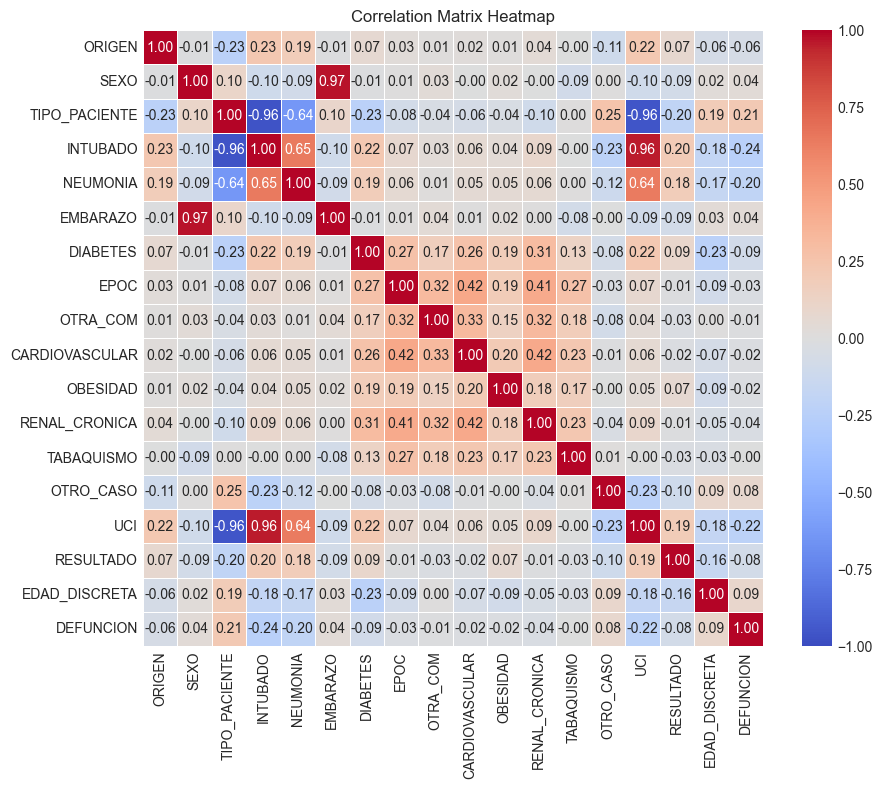

In [207]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='white')

# Set title
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

In [67]:
DATA = data[['ORIGEN', 'INTUBADO', 'NEUMONIA', 'DIABETES', 'EPOC', 'OBESIDAD', 'RENAL_CRONICA', 'UCI', 'RESULTADO', 'DEFUNCION']].copy()

In [68]:
Y = np.array(DATA['DEFUNCION'])
X = np.array(DATA.drop(columns='DEFUNCION', inplace=False))

In [69]:
X.shape, Y.shape

((263007, 9), (263007,))

In [70]:
data['DEFUNCION'].value_counts()

0    258465
1      4542
Name: DEFUNCION, dtype: int64

## Split into train and test split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(210405, 9) (210405,)
(52602, 9) (52602,)


## Balance classes

In [72]:
# Perform undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Perform oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)

In [73]:
ros = SMOTE(sampling_strategy=0.035)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

In [74]:
from collections import Counter

print("Original dataset shape:", Counter(y_train))
print("Resampled dataset shape:", Counter(y_resampled))

Original dataset shape: Counter({0: 206796, 1: 3609})
Resampled dataset shape: Counter({0: 7237, 1: 7237})


### Verificar distribucion

In [75]:
df_unbalanced = pd.DataFrame(X_train, columns=DATA.columns[:-1])
df_unbalanced['DEF'] = y_train
df_unbalanced

,ORIGEN,INTUBADO,NEUMONIA,DIABETES,EPOC,OBESIDAD,RENAL_CRONICA,UCI,RESULTADO,DEF
0,-1.322453,-1.603785,0.438877,-2.434778,0.069691,0.403346,0.077578,-1.569084,-1.249953,0
1,0.756170,-1.603785,-2.269016,0.338987,0.069691,-2.131331,0.077578,-1.569084,0.800030,0
2,0.756170,-1.603785,0.438877,-2.434778,0.069691,0.403346,0.077578,-3.672335,-1.249953,0
3,0.756170,0.537061,0.438877,-2.434778,0.069691,-2.131331,0.077578,0.534167,0.800030,0
4,0.756170,0.537061,0.438877,0.338987,0.069691,0.403346,0.077578,0.534167,-1.249953,0
...,...,...,...,...,...,...,...,...,...,...
210400,0.756170,0.537061,0.438877,0.338987,0.069691,0.403346,0.077578,0.534167,0.800030,0
210401,-1.322453,-1.603785,-2.269016,0.338987,0.069691,0.403346,0.077578,-1.569084,-1.249953,0
210402,0.756170,-1.603785,-2.269016,0.338987,0.069691,0.403346,0.077578,-1.569084,-1.249953,0
210403,0.756170,0.537061,0.438877,0.338987,0.069691,0.403346,0.077578,0.534167,0.800030,0


In [76]:
df_balanced = pd.DataFrame(X_resampled, columns=DATA.columns[:-1])
df_balanced['DEF'] = y_resampled
df_balanced

,ORIGEN,INTUBADO,NEUMONIA,DIABETES,EPOC,OBESIDAD,RENAL_CRONICA,UCI,RESULTADO,DEF
0,-1.322453,0.537061,0.438877,0.338987,0.069691,0.403346,0.077578,0.534167,0.800030,0
1,0.756170,0.537061,0.438877,0.338987,0.069691,0.403346,0.077578,0.534167,-1.249953,0
2,-1.322453,0.537061,0.438877,-2.434778,0.069691,0.403346,0.077578,0.534167,0.800030,0
3,0.756170,0.537061,0.438877,0.338987,0.069691,0.403346,0.077578,0.534167,-1.249953,0
4,0.756170,0.537061,0.438877,0.338987,0.069691,0.403346,0.077578,0.534167,0.800030,0
...,...,...,...,...,...,...,...,...,...,...
14469,-1.322453,-3.744632,-2.269016,-2.434778,0.069691,0.403346,0.077578,-1.569084,-1.249953,1
14470,-1.322453,0.537061,-2.269016,-2.434778,0.069691,0.403346,0.077578,0.534167,-1.249953,1
14471,-1.322453,-3.744632,-2.269016,0.338987,0.069691,0.403346,0.077578,-1.569084,-1.249953,1
14472,0.756170,-1.603785,0.438877,-2.434778,0.069691,-2.131331,0.077578,-1.569084,0.800030,1


In [77]:
df_unbalanced_0 = df_unbalanced.loc[df_unbalanced['DEF']==0]
df_unbalanced_1 = df_unbalanced.loc[df_unbalanced['DEF']==1]

df_balanced_0 = df_balanced.loc[df_balanced['DEF']==0]
df_balanced_1 = df_balanced.loc[df_balanced['DEF']==1]

In [78]:
print(df_unbalanced_0.shape, df_unbalanced_1.shape)
print(df_balanced_0.shape, df_balanced_1.shape)

(206796, 10) (3609, 10)
(7237, 10) (7237, 10)


In [79]:
df_balanced_0.columns[:-1]

Index(['ORIGEN', 'INTUBADO', 'NEUMONIA', 'DIABETES', 'EPOC', 'OBESIDAD',
       'RENAL_CRONICA', 'UCI', 'RESULTADO'],
      dtype='object')

In [80]:
def graficar_distribuciones(datos, titulo):
    fig, axs = plt.subplots(1, 9, figsize=(15, 4))
    axs = axs.ravel()
    
    data = df_balanced_0
    
    for i, atributo in enumerate(datos.columns[:-1]):
        axs[i].hist(datos[atributo], bins=5, edgecolor='black')
        axs[i].set_title(atributo)
        axs[i].set_xlim((-5,10))
    
    fig.suptitle(titulo, fontsize = 15)
    plt.tight_layout()

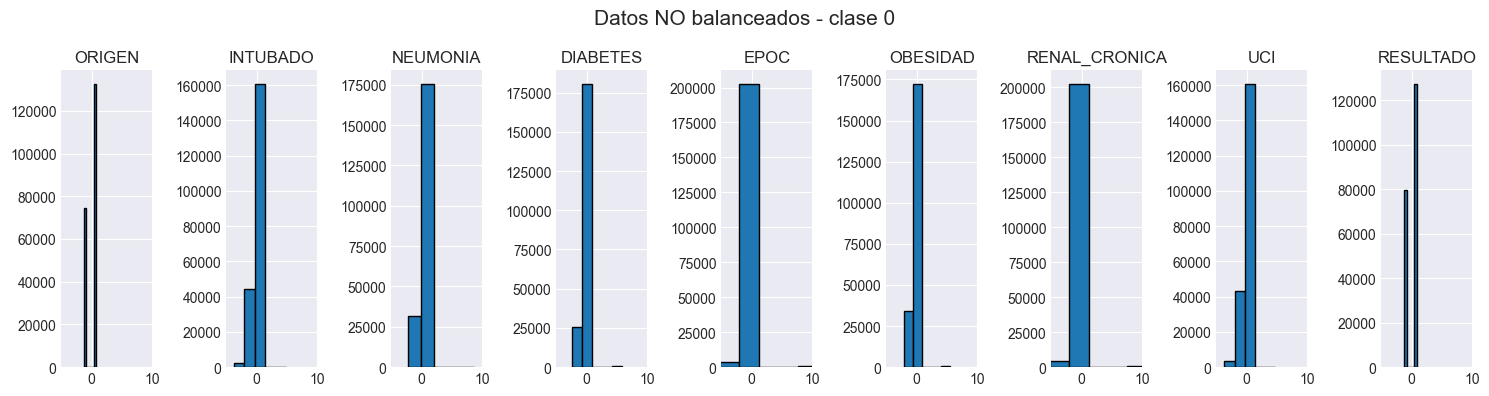

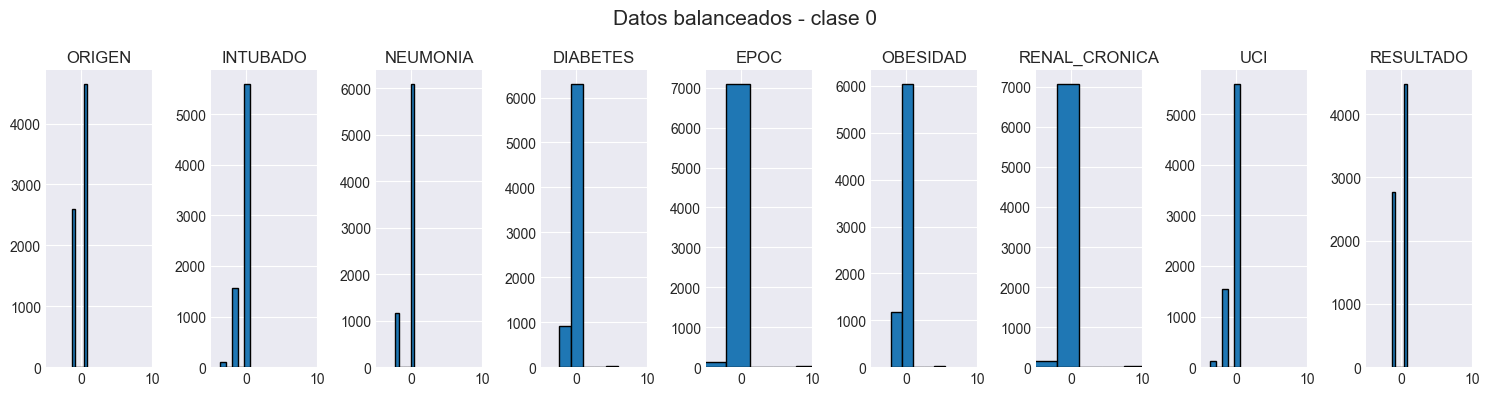

In [81]:
graficar_distribuciones(df_unbalanced_0, 'Datos NO balanceados - clase 0')
graficar_distribuciones(df_balanced_0, 'Datos balanceados - clase 0')

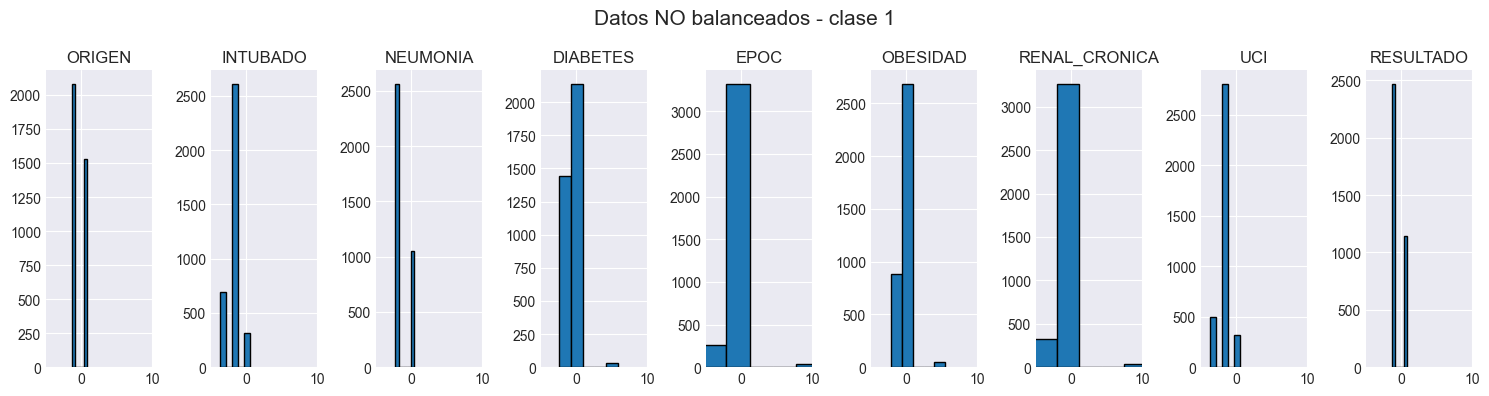

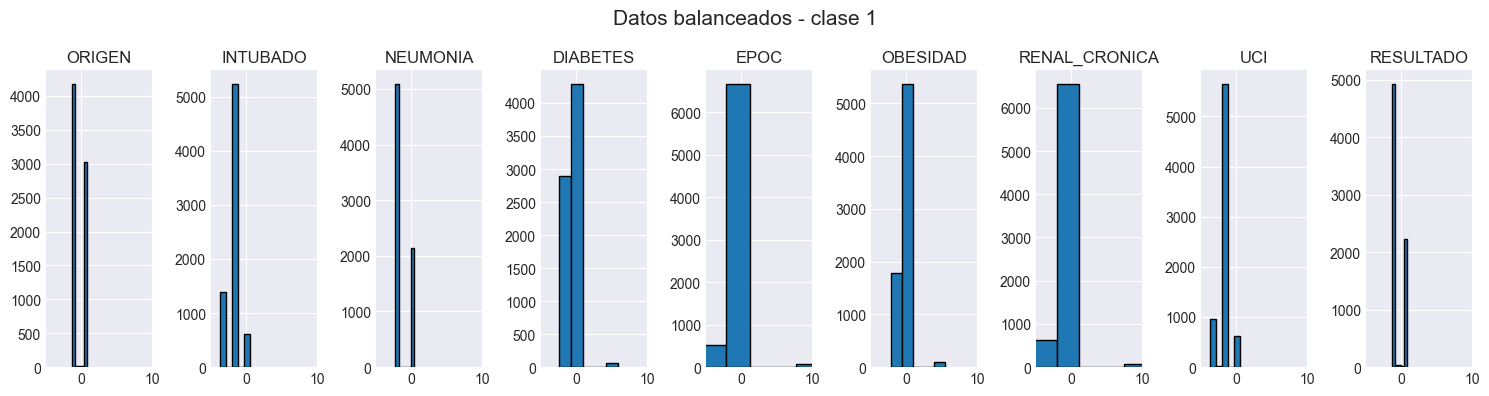

In [82]:
graficar_distribuciones(df_unbalanced_1, 'Datos NO balanceados - clase 1')
graficar_distribuciones(df_balanced_1, 'Datos balanceados - clase 1')

## MODELOS

In [83]:
def reporte_clasificacion_y_matriz_confusion(y_test, y_pred):
    from sklearn.metrics import confusion_matrix

    # Example: Detailed classification report
    print(classification_report(y_test, y_pred))
    
    #confusion_matrix = confusion_matrix(y_test, np.argmax(y_pred, axis = 1))
    confusion_matrix = confusion_matrix(y_test, y_pred)
    
    # Create a figure and a single subplot
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    
    # Plot the confusion matrix
    im = ax.imshow(confusion_matrix,
                   cmap='summer',
                   interpolation='nearest')
    
    # Add values inside the cells
    for j in range(2):
        for k in range(2):
            ax.text(k, j, str(confusion_matrix[j, k]), ha='center', va='center', color='black')
    
    # Add labels, title, etc.
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    #ax.set_xticks([0, 1,2,3,4, 5, 6, 7,], labels=['Si', 'No', 'Baño', 'Hambre', 'Sed', 'Ayuda', 'Dolor', 'Gracias'])
    #ax.set_yticks([0, 1,2,3,4, 5, 6, 7,], labels=['Si', 'No', 'Baño', 'Hambre', 'Sed', 'Ayuda', 'Dolor', 'Gracias'])
    ax.set_xticks([0, 1], labels=['Vivo', 'Defuncion'])
    ax.set_yticks([0, 1], labels=['Vivo', 'Defuncion'])
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)
    ax.grid(False)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    # Show plot
    plt.show()

In [84]:
def generar_clasificacion(x_train=None, y_train=None, x_test=None, y_test=None, modelo=None):
    modelo.fit(x_train, y_train)
    y_pred = modelo.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f'Kappa Coefficient: {kappa:.2f}')
    
    reporte_clasificacion_y_matriz_confusion(y_test, y_pred)

### SVM

Accuracy: 0.76
Kappa Coefficient: 0.10
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     51669
           1       0.07      0.95      0.13       933

    accuracy                           0.76     52602
   macro avg       0.53      0.86      0.49     52602
weighted avg       0.98      0.76      0.85     52602


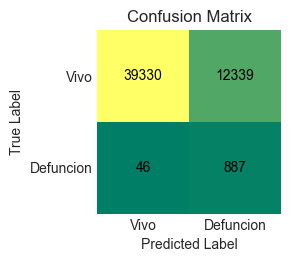

In [85]:
generar_clasificacion(x_train=X_resampled, y_train=y_resampled, x_test=X_test, y_test=y_test,
                      modelo=SVC(kernel='rbf'))

### XGBoost

Accuracy: 0.78
Kappa Coefficient: 0.10
              precision    recall  f1-score   support

           0       1.00      0.78      0.88     51669
           1       0.07      0.92      0.13       933

    accuracy                           0.78     52602
   macro avg       0.53      0.85      0.50     52602
weighted avg       0.98      0.78      0.86     52602


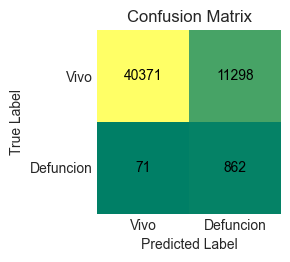

In [86]:
generar_clasificacion(x_train=X_resampled, y_train=y_resampled, x_test=X_test, y_test=y_test,
                      modelo=XGBClassifier())

### Logistic Regression

Accuracy: 0.81
Kappa Coefficient: 0.11
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     51669
           1       0.08      0.87      0.14       933

    accuracy                           0.81     52602
   macro avg       0.54      0.84      0.52     52602
weighted avg       0.98      0.81      0.88     52602


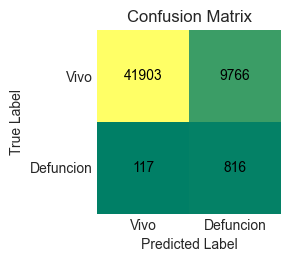

In [87]:
generar_clasificacion(x_train=X_resampled, y_train=y_resampled, x_test=X_test, y_test=y_test,
                      modelo=LogisticRegression())

### Random Forest Classifier

Accuracy: 0.77
Kappa Coefficient: 0.10
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     51669
           1       0.07      0.94      0.13       933

    accuracy                           0.77     52602
   macro avg       0.53      0.85      0.50     52602
weighted avg       0.98      0.77      0.86     52602


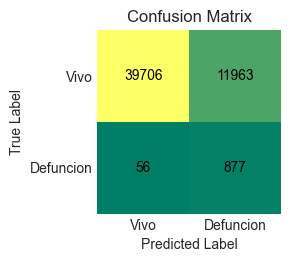

In [88]:
generar_clasificacion(x_train=X_resampled, y_train=y_resampled, x_test=X_test, y_test=y_test,
                      modelo=RandomForestClassifier(n_estimators=100, random_state=42))

### Decision Tree Classifier

Accuracy: 0.79
Kappa Coefficient: 0.10
              precision    recall  f1-score   support

           0       1.00      0.78      0.88     51669
           1       0.07      0.91      0.13       933

    accuracy                           0.79     52602
   macro avg       0.53      0.85      0.50     52602
weighted avg       0.98      0.79      0.86     52602


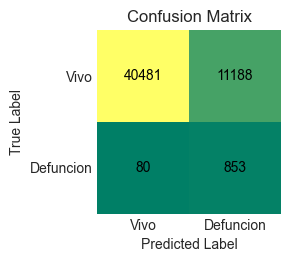

In [89]:
generar_clasificacion(x_train=X_resampled, y_train=y_resampled, x_test=X_test, y_test=y_test,
                      modelo=DecisionTreeClassifier(random_state=42))

### k-Nearest Neighbors Classifier

Accuracy: 0.89
Kappa Coefficient: 0.13
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     51669
           1       0.09      0.59      0.16       933

    accuracy                           0.89     52602
   macro avg       0.54      0.74      0.55     52602
weighted avg       0.98      0.89      0.93     52602


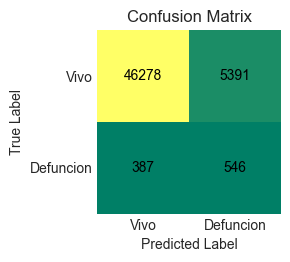

In [90]:
generar_clasificacion(x_train=X_resampled, y_train=y_resampled, x_test=X_test, y_test=y_test,
                      modelo=KNeighborsClassifier(n_neighbors=67))

### Gaussian Naive Bayes

Accuracy: 0.80
Kappa Coefficient: 0.11
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     51669
           1       0.07      0.88      0.14       933

    accuracy                           0.80     52602
   macro avg       0.54      0.84      0.51     52602
weighted avg       0.98      0.80      0.88     52602


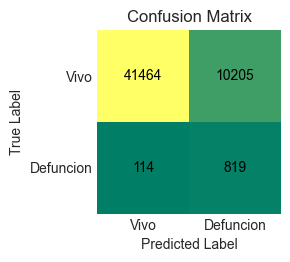

In [91]:
generar_clasificacion(x_train=X_resampled, y_train=y_resampled, x_test=X_test, y_test=y_test,
                      modelo=GaussianNB())

### Gradient Boosting Classifier

Accuracy: 0.79
Kappa Coefficient: 0.10
              precision    recall  f1-score   support

           0       1.00      0.78      0.88     51669
           1       0.07      0.93      0.13       933

    accuracy                           0.79     52602
   macro avg       0.54      0.86      0.51     52602
weighted avg       0.98      0.79      0.86     52602


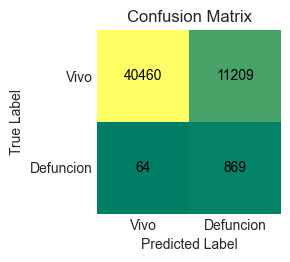

In [92]:
generar_clasificacion(x_train=X_resampled, y_train=y_resampled, x_test=X_test, y_test=y_test,
                      modelo=GradientBoostingClassifier(n_estimators=100, random_state=42))

### FCNN

In [94]:
FCNN = Sequential([
    Dense(2, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer with 10 neurons
    #Dense(4, activation='relu'),  # Second hidden layer with 10 neurons
    #Dense(2, activation='relu'),  # Second hidden layer with 10 neurons
    Dense(1, activation='sigmoid')  # Output layer with 2 neurons (for 2 classes)
])

FCNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )

Epoch 1/20
181/181 [==============================] - 2s 3ms/step - loss: 0.9823 - accuracy: 0.4360 - val_loss: 0.3622 - val_accuracy: 0.8328
Epoch 2/20
181/181 [==============================] - 0s 2ms/step - loss: 0.9492 - accuracy: 0.6123 - val_loss: 0.3679 - val_accuracy: 0.8328
Epoch 3/20
181/181 [==============================] - 0s 2ms/step - loss: 0.9216 - accuracy: 0.6129 - val_loss: 0.3735 - val_accuracy: 0.8345
Epoch 4/20
181/181 [==============================] - 0s 2ms/step - loss: 0.8957 - accuracy: 0.6131 - val_loss: 0.3789 - val_accuracy: 0.8345
Epoch 5/20
181/181 [==============================] - 0s 2ms/step - loss: 0.8709 - accuracy: 0.6131 - val_loss: 0.3835 - val_accuracy: 0.8345
Epoch 6/20
181/181 [==============================] - 0s 2ms/step - loss: 0.8473 - accuracy: 0.6260 - val_loss: 0.3881 - val_accuracy: 0.8276
Epoch 7/20
181/181 [==============================] - 0s 2ms/step - loss: 0.8250 - accuracy: 0.6308 - val_loss: 0.3927 - val_accuracy: 0.8276
Epoch 

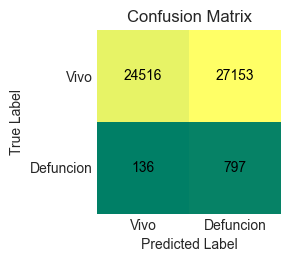

In [95]:
history = FCNN.fit(X_resampled, y_resampled, epochs=20, validation_split=0.2, batch_size=64,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=10,
                                                                restore_best_weights=True
                                                                )])

y_pred = FCNN.predict(X_test)
y_pred = [0 if pred < .5 else 1 for pred in y_pred]
    
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

kappa = cohen_kappa_score(y_test, y_pred)
print(f'Kappa Coefficient: {kappa:.2f}')

reporte_clasificacion_y_matriz_confusion(y_test, y_pred)

## Optimizar hiperparametros

In [96]:
def optimizar_hiperparametros(X_train, y_train, X_test, y_test):
    
    C = (.1, .01, .001, .0001)
    kernel = ('linear', 'poly', 'rbf')
    gamma = ('scale', .1, .01, .001)
    
    
    mejor_acc = 0
    mejores_hiperparametros = None
    
    for c, k, g in tqdm(list(itertools.product(C, kernel, gamma))):
        
        model = SVC(C= c, kernel = k, gamma = g)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
    
        acc = accuracy_score(y_test, y_pred)
        
        if acc > mejor_acc:
            mejor_acc = acc
            mejores_hiperparametros = {'C' : c,
                                       'kernel' : k,
                                       'gamma' : g}
        
    return mejor_acc, mejores_hiperparametros

In [97]:
mejor_acc, mejores_hiperparametros = optimizar_hiperparametros(X_resampled, y_resampled, X_test, y_test)

100%|██████████| 48/48 [15:37<00:00, 19.53s/it]


In [98]:
print(mejor_acc, mejores_hiperparametros)

0.9809703053115851 {'C': 0.01, 'kernel': 'poly', 'gamma': 0.01}


Accuracy: 0.98
Kappa Coefficient: 0.03
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     51669
           1       0.15      0.02      0.03       933

    accuracy                           0.98     52602
   macro avg       0.57      0.51      0.51     52602
weighted avg       0.97      0.98      0.97     52602


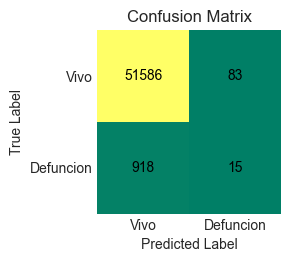

In [99]:
generar_clasificacion(x_train=X_resampled, y_train=y_resampled, x_test=X_test, y_test=y_test,
                      modelo=SVC(C= mejores_hiperparametros['C'],
                      kernel = mejores_hiperparametros['kernel'],
                      gamma = mejores_hiperparametros['gamma']))

## Validación cruzada

Debo tomar todos los datos, es decir, sin hacer split en train y test

In [105]:
def validacion_cruzada(x_data, y_target, model, iters=30, k_folds=10):
    
    iter_cv_scores = []
    for _ in tqdm(range(iters), desc = 'Iteraciones de CV'):
        
        #Balancear clases
        #remuestreo clase minoritaria
        ros = SMOTE(sampling_strategy=0.035148)
        X_resampled, y_resampled = ros.fit_resample(x_data, y_target)
        #submuestreo clase mayoritaria
        rus = RandomUnderSampler(random_state=None)
        X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)
    
        #Normalizar datos
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_resampled)
        
        # k folds
        folds = KFold(n_splits=k_folds, random_state = None, shuffle=True)
        
        # CV
        cv_scores = cross_val_score(model,
                                X_scaled,
                                y_resampled,
                                cv=folds)
        
        # Guardar scores en lista
        iter_cv_scores.append(cv_scores)
    return np.array(iter_cv_scores)

In [113]:
modelo = SVC(kernel='rbf')

cross_scores = validacion_cruzada(X, Y, modelo, iters=30, k_folds=10)

Iteraciones de CV: 100%|██████████| 30/30 [16:08<00:00, 32.27s/it]


In [114]:
cross_scores

array([[0.85910842, 0.8684645 , 0.864612  , 0.8436984 , 0.85140341,
        0.85305449, 0.85690699, 0.84589983, 0.85627753, 0.84471366],
       [0.86130985, 0.85085305, 0.85635663, 0.8398459 , 0.86020914,
        0.86571271, 0.85745735, 0.8503027 , 0.85627753, 0.85627753],
       [0.85360484, 0.85855806, 0.84975234, 0.86406164, 0.8684645 ,
        0.8503027 , 0.84700055, 0.85470556, 0.85407489, 0.86013216],
       [0.84975234, 0.85085305, 0.85525592, 0.83764447, 0.85580627,
        0.86020914, 0.86186021, 0.86516236, 0.8595815 , 0.85737885],
       [0.86791414, 0.85635663, 0.864612  , 0.86130985, 0.85525592,
        0.84314805, 0.84755091, 0.86186021, 0.86674009, 0.86013216],
       [0.85305449, 0.86681343, 0.85140341, 0.85360484, 0.86791414,
        0.8684645 , 0.85855806, 0.83819483, 0.85737885, 0.83535242],
       [0.84810127, 0.84589983, 0.85800771, 0.85800771, 0.86241057,
        0.85305449, 0.86626307, 0.85470556, 0.86068282, 0.86123348],
       [0.85140341, 0.8436984 , 0.8458998

In [115]:
cross_scores_mean = []
cross_scores_std = []
for i in range(cross_scores.shape[0]):
    cross_scores_mean.append(np.array(cross_scores[i,:]).mean())
    cross_scores_std.append(np.array(cross_scores[i,:]).std())

In [121]:
cv_scores= np.array(cross_scores_mean)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")
print(f"Standard deviation of cross-validation score: {cv_scores.std()}")

Cross-validation scores: [0.85441392 0.85546024 0.85606572 0.85535041 0.858488   0.8550739
 0.85683665 0.85364385 0.85480023 0.85782702 0.85815693 0.85821221
 0.85529465 0.85980831 0.85661557 0.85402913 0.85298308 0.85744241
 0.85232232 0.85601069 0.85843175 0.85843299 0.85958923 0.85700091
 0.85298293 0.85441486 0.85727733 0.85138653 0.85771719 0.85336891]
Mean cross-validation score: 0.8559812621779781
Standard deviation of cross-validation score: 0.0021980062845558266


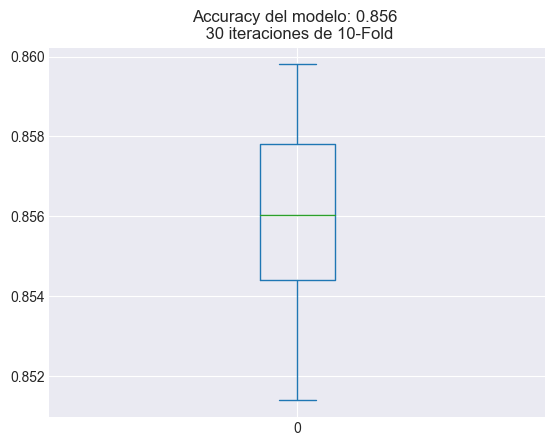

In [132]:
pd.DataFrame(cv_scores).plot(kind='box');
            plt.title(f'Accuracy del modelo: {round(cv_scores.mean(), 4)} \n 30 iteraciones de 10-Fold');